## Вводные по кейсу

# Описание данных

## Таблица `Users`

| Поле              | Описание                                       |
|-------------------|------------------------------------------------|
| `user_id`         | Уникальный идентификатор пользователя.         |
| `registration_date` | Дата регистрации пользователя.                |
| `age`             | Возраст пользователя.                          |
| `gender`          | Пол.                                |
| `region`          | Регион.                                        |
| `acq_channel`     | Канал привлечения.                             |
| `buyer_segment`   | Сегмент покупателя.                            |
| `cohort_week`     | Неделя привлечения.|
| `cohort_month`    | Месяц привлечения. |

---

## Таблица `Events`

| Поле          | Описание                                                                 |
|---------------|--------------------------------------------------------------------------|
| `event_id`    | Уникальный идентификатор события.                                        |
| `user_id`     | Идентификатор пользователя.                                              |
| `event_date`  | Дата события.                                                            |
| `event_type`  | Тип события.   |
| `os`          | Операционная система.               |
| `device`      | Тип устройства.                                |
| `product_name`| Наименование товара, к которому относится событие (если применимо).      |
| `event_week`  | Неделя события.                                          |
| `event_month` | Месяц события .                                           |

---

## Таблица `Orders`

| Поле          | Описание                                                                 |
|---------------|--------------------------------------------------------------------------|
| `order_id`    | Уникальный идентификатор заказа.                                         |
| `user_id`     | Идентификатор пользователя, который сделал заказ |
| `order_date`  | Дата и время оформления заказа.                                          |
| `product_name`| Наименование товара.                                                     |
| `quantity`    | Количество единиц товара в заказе.                                       |
| `unit_price`  | Цена за одну единицу товара.                                             |
| `total_price` | Итоговая сумма заказа.                                                   |
| `category_name` | Наименование категории товара.                                         |
| `order_week`  | Неделя заказа.                                           |
| `order_month` | Месяц заказа.                                            |


## Таблица `Campaign_costs`

| Поле         | Описание                                                                 |
|--------------|--------------------------------------------------------------------------|
| `acq_channel`| Канал привлечения.  |
| `spend_month`| Месяц, в который был потрачен бюджет (отражает период, в котором были привлечены пользователи)                      |
| `budget`     | Маркетинговый бюджет (в денежном выражении), потраченный на данный канал в указанном месяце.                           |



## Описание событий

| Событие             | Описание                                                                                  |
|---------------------|-------------------------------------------------------------------------------------------|
| `page_view`         | Открытие любой страницы сайта или приложения пользователем.                                |
| `product_view`      | Просмотр страницы конкретного товара.                                                     |
| `product_click`     | Клик по товару (например, из списка товаров или на баннере).                              |
| `add_to_cart`       | Добавление товара в корзину.                                                              |
| `remove_from_cart`  | Удаление товара из корзины.                                                               |
| `search`            | Выполнение поиска по сайту или приложению.                                                |
| `filter_apply`      | Применение фильтра (например, по цене, бренду, категории).                                |
| `checkout_start`    | Начало оформления заказа (переход к оформлению корзины).                                  |
| `checkout_complete` | Завершение оформления заказа (не гарантирует покупку, покупка зависит от факта оплаты).                                          |
| `user_login`        | Вход пользователя в личный кабинет или аккаунт.                                           |
| `user_logout`       | Выход пользователя из аккаунта.                                                           |
| `wishlist_add`      | Добавление товара в список желаемого (wishlist).                                          |
| `category_view`     | Просмотр страницы категории товаров.                                                      |
| `banner_click`      | Клик по рекламному баннеру на сайте или в приложении.                                     |
| `promo_view`        | Просмотр промо-акции или специального предложения.                                        |


## Выручка маркетплейса = 5% от total_price

# Блок кода и расчета метрик

### 1. Загрузка данных и их предобработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
pa_marketplace_orders = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders.csv', parse_dates = ['order_date', 'order_week', 'order_month'])
pa_marketplace_campaign_costs = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_campaign_costs.csv', parse_dates = ['spend_month'])
pa_marketplace_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users.csv', parse_dates = ['registration_date', 'cohort_week', 'cohort_month'])
pa_marketplace_events = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events.csv', parse_dates = ['event_date', 'event_week', 'event_month'])

#### pa_marketplace_orders

In [3]:
display(pa_marketplace_orders.head())
display(pa_marketplace_orders.info())

,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
0,1,3,2024-01-19 01:52:52,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
1,2,3,2024-01-19 01:52:52,Молоток слесарный,1,11340.38,11340.38,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
2,3,3,2024-01-19 01:52:52,Секатор садовый,2,10892.09,21784.18,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
3,4,3,2024-01-25 13:59:38,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-22,2024-01-01
4,5,3,2024-01-25 13:59:38,Чай черный,1,2099.59,2099.59,Продукты питания,2024-01-22,2024-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31357 entries, 0 to 31356
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       31357 non-null  int64         
 1   user_id        31357 non-null  int64         
 2   order_date     31357 non-null  datetime64[ns]
 3   product_name   31357 non-null  object        
 4   quantity       31357 non-null  int64         
 5   unit_price     31357 non-null  float64       
 6   total_price    31357 non-null  float64       
 7   category_name  31357 non-null  object        
 8   order_week     31357 non-null  datetime64[ns]
 9   order_month    31357 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 2.4+ MB


None

In [4]:
df_null_orders = pa_marketplace_orders.isnull().sum().sum()
df_dp_orders = pa_marketplace_orders.duplicated().sum()
unic_users_orders = pa_marketplace_orders['user_id'].nunique()

print(f'Полных дупликатов {df_dp_orders},пропусков {df_null_orders}, уникальных пользователей: {unic_users_orders}')

Полных дупликатов 0,пропусков 0, уникальных пользователей: 8922


In [5]:
unic_users_1 = pa_marketplace_orders.duplicated(subset = ['user_id']).sum()
timestamp_duplicates = pa_marketplace_orders.duplicated(subset=['user_id', 'product_name']).sum()

print(f'Количество неявных дубликатов {unic_users_1} и дубликатов когда один пользователь в одно время сделал одну покупку дважды {timestamp_duplicates}')

Количество неявных дубликатов 22435 и дубликатов когда один пользователь в одно время сделал одну покупку дважды 3644


In [6]:
category_name_uniq = pa_marketplace_orders['category_name'].unique()
category_name_uniq_c = pa_marketplace_orders['category_name'].nunique()

print(f'Уникальные события: \n{category_name_uniq}')
print(f'\nКол-во уникальных событий {category_name_uniq_c}')

print(f"\nДанные с {pa_marketplace_orders['order_date'].min()} по {pa_marketplace_orders['order_date'].max()}")

Уникальные события: 
['Инструменты и садовый инвентарь' 'Продукты питания' 'Женская одежда'
 'Аксессуары для гаджетов' 'Одежда для спорта' 'Декор и освещение'
 'Детская одежда' 'Детские игрушки' 'Книги и канцтовары'
 'Медицинские товары' 'Косметика и парфюмерия' 'Товары для туризма'
 'Сумки и аксессуары' 'Автотовары' 'Обувь мужская' 'Обувь женская'
 'Мужская одежда' 'Бытовая техника' 'Зоотовары' 'Товары для кухни'
 'Средства для ухода' 'Мебель для дома' 'Спортивный инвентарь'
 'Товары для новорожденных' 'Украшения и часы']

Кол-во уникальных событий 25

Данные с 2024-01-01 08:03:45 по 2024-12-31 23:00:53


#### pa_marketplace_campaign_costs

In [7]:
display(pa_marketplace_campaign_costs.head())
display(pa_marketplace_campaign_costs.info())

,Unnamed: 0,acq_channel,spend_month,budget
0,0,Affiliate,2024-01-01,179343.3875
1,1,Affiliate,2024-02-01,175488.4875
2,2,Affiliate,2024-03-01,164543.4750
3,3,Affiliate,2024-04-01,186869.9750
4,4,Affiliate,2024-05-01,166443.7750


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   88 non-null     int64         
 1   acq_channel  88 non-null     object        
 2   spend_month  88 non-null     datetime64[ns]
 3   budget       88 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.9+ KB


None

In [8]:
pa_marketplace_campaign_costs_redact = pa_marketplace_campaign_costs.drop(columns=['Unnamed: 0'])

display(pa_marketplace_campaign_costs_redact.head())

,acq_channel,spend_month,budget
0,Affiliate,2024-01-01,179343.3875
1,Affiliate,2024-02-01,175488.4875
2,Affiliate,2024-03-01,164543.4750
3,Affiliate,2024-04-01,186869.9750
4,Affiliate,2024-05-01,166443.7750


In [9]:
df_null_costs = pa_marketplace_campaign_costs_redact.isnull().sum().sum()
df_dp_costs = pa_marketplace_campaign_costs_redact.duplicated().sum()
unic_channel_orders = pa_marketplace_campaign_costs_redact['acq_channel'].nunique()

print(f'Полных дупликатов {df_dp_costs},пропусков {df_null_costs}, уникальных каналов: {unic_channel_orders}')

Полных дупликатов 0,пропусков 0, уникальных каналов: 7


In [10]:
unic_channel_1 = pa_marketplace_campaign_costs_redact.duplicated(subset = ['acq_channel']).sum()

print(f'Количество неявных дубликатов {unic_channel_1}')

Количество неявных дубликатов 81


In [11]:
campaign_costs_uniq = pa_marketplace_campaign_costs_redact['acq_channel'].unique()
campaign_costs_uniq_c = pa_marketplace_campaign_costs_redact['acq_channel'].nunique()

print(f'Уникальные каналы: \n{campaign_costs_uniq}')
print(f'\nКол-во уникальных каналов {campaign_costs_uniq_c}')

print(f"\nДанные с {pa_marketplace_campaign_costs_redact['spend_month'].min()} по {pa_marketplace_campaign_costs_redact['spend_month'].max()}")

Уникальные каналы: 
['Affiliate' 'Direct' 'Email Marketing' 'Social Media' 'Google Ads' 'SEO'
 'TikTok']

Кол-во уникальных каналов 7

Данные с 2024-01-01 00:00:00 по 2025-01-01 00:00:00


#### pa_marketplace_users

In [12]:
display(pa_marketplace_users.head())
display(pa_marketplace_users.info())

,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month
0,1,2024-01-01 00:47:00,35,M,Москва,Google Ads,regular,2024-01-01,2024-01-01
1,2,2024-01-01 19:01:00,53,M,Москва,Email Marketing,rare,2024-01-01,2024-01-01
2,3,2024-01-01 04:13:00,66,F,Санкт-Петербург,Google Ads,regular,2024-01-01,2024-01-01
3,4,2024-01-01 17:18:00,58,M,Краснодар,Affiliate,one_time,2024-01-01,2024-01-01
4,5,2024-01-01 08:29:00,58,F,Другие регионы,Google Ads,regular,2024-01-01,2024-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44151 entries, 0 to 44150
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            44151 non-null  int64         
 1   registration_date  44151 non-null  datetime64[ns]
 2   age                44151 non-null  int64         
 3   gender             44151 non-null  object        
 4   region             44151 non-null  object        
 5   acq_channel        44151 non-null  object        
 6   buyer_segment      44151 non-null  object        
 7   cohort_week        44151 non-null  datetime64[ns]
 8   cohort_month       44151 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 3.0+ MB


None

In [13]:
df_null_users = pa_marketplace_users.isnull().sum().sum()
df_dp_users = pa_marketplace_users.duplicated().sum()
unic_users_users = pa_marketplace_users['user_id'].nunique()

print(f'Полных дупликатов {df_dp_users},пропусков {df_null_users}, уникальных пользователей: {unic_users_users}')

Полных дупликатов 0,пропусков 0, уникальных пользователей: 44151


In [14]:
unic_users_2 = pa_marketplace_users.duplicated(subset = ['user_id']).sum()
timestamp_duplicates = pa_marketplace_users.duplicated(subset=['user_id', 'registration_date']).sum()

print(f'Количество неявных дубликатов {unic_users_2} и дубликатов когда один пользователь в одно время зарегестрировался дважды: {timestamp_duplicates}')

Количество неявных дубликатов 0 и дубликатов когда один пользователь в одно время зарегестрировался дважды: 0


In [15]:
segment_uniq = pa_marketplace_users['buyer_segment'].unique()
segment_uniq_c = pa_marketplace_users['buyer_segment'].nunique()

print(f'Уникальный сегмент: \n{segment_uniq}')
print(f'\nКол-во уникальных сегментов {segment_uniq_c}')

print(f"\nДанные с {pa_marketplace_users['registration_date'].min()} по {pa_marketplace_users['registration_date'].max()}")

Уникальный сегмент: 
['regular' 'rare' 'one_time' 'medium']

Кол-во уникальных сегментов 4

Данные с 2024-01-01 00:07:00 по 2024-12-31 23:44:00


#### pa_marketplace_events

In [16]:
display(pa_marketplace_events.head())
display(pa_marketplace_events.info())

,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month
0,3132,100,2024-01-01,page_view,iOS,mobile,NaN,2024-01-01,2024-01-01
1,3133,100,2024-01-01,product_view,iOS,mobile,Шорты для тренировок,2024-01-01,2024-01-01
2,3134,100,2024-01-01,product_click,iOS,mobile,Куртка детская,2024-01-01,2024-01-01
3,3135,100,2024-01-01,add_to_cart,iOS,mobile,Балетки классические,2024-01-01,2024-01-01
4,3136,100,2024-01-01,checkout_start,iOS,mobile,NaN,2024-01-01,2024-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785859 entries, 0 to 785858
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      785859 non-null  int64         
 1   user_id       785859 non-null  int64         
 2   event_date    785859 non-null  datetime64[ns]
 3   event_type    785859 non-null  object        
 4   os            785859 non-null  object        
 5   device        785859 non-null  object        
 6   product_name  385740 non-null  object        
 7   event_week    785859 non-null  datetime64[ns]
 8   event_month   785859 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 54.0+ MB


None

In [17]:
df_null_events = pa_marketplace_events.isnull().sum().sum()
df_dp_events = pa_marketplace_events.duplicated().sum()
unic_users_events = pa_marketplace_events['user_id'].nunique()

print(f'Полных дупликатов {df_dp_events},пропусков {df_null_events}, уникальных пользователей: {unic_users_events}')

Полных дупликатов 0,пропусков 400119, уникальных пользователей: 22138


In [18]:
unic_users_3 = pa_marketplace_events.duplicated(subset = ['user_id']).sum()
timestamp_duplicates = pa_marketplace_events.duplicated(subset=['user_id', 'event_date']).sum()

print(f'Количество неявных дубликатов {unic_users_3} и дубликатов когда один пользователь в одно время зарегестрировался дважды: {timestamp_duplicates}')

Количество неявных дубликатов 763721 и дубликатов когда один пользователь в одно время зарегестрировался дважды: 673795


In [19]:
event_uniq = pa_marketplace_events['event_type'].unique()
event_uniq_c = pa_marketplace_events['event_type'].nunique()

print(f'Уникальный тип: \n{event_uniq}')
print(f'\nКол-во уникальных типов {event_uniq_c}')

print(f"\nДанные с {pa_marketplace_events['event_date'].min()} по {pa_marketplace_events['event_date'].max()}")

Уникальный тип: 
['page_view' 'product_view' 'product_click' 'add_to_cart' 'checkout_start'
 'checkout_complete' 'user_logout' 'search' 'category_view' 'filter_apply'
 'promo_view' 'wishlist_add' 'user_login' 'banner_click'
 'remove_from_cart']

Кол-во уникальных типов 15

Данные с 2024-01-01 00:00:00 по 2024-12-31 00:00:00


In [20]:
print("\nРаспределение по OS:")
print(pa_marketplace_events['os'].value_counts(normalize=True) * 100)

print("\nРаспределение по устройствам:")
print(pa_marketplace_events['device'].value_counts(normalize=True) * 100)


Распределение по OS:
Windows    25.513355
Android    25.188361
iOS        24.883726
macOS      24.414558
Name: os, dtype: float64

Распределение по устройствам:
mobile     33.529552
tablet     33.248713
desktop    33.221736
Name: device, dtype: float64


**Промежуточный выывод**

Познакомился с данными и провел предобратоку данных. Данные в целом имебт хороший вид. Неявные дубликаты и пропуски присутсвуют,но в контексте нашей задачи являются нормальными(Один пользователь может купить несколько одинаковых таваров в разное время,пропуски тожк норма т.к. не все события должны иметь product_name).

- Загрузили необходимые библиотеки
- Выгрузили и познакомились с датами
- "Спарсили" даты этапе загрузки данных
- Проверели на пропуски и дубликаты
- Удалили ненужный столбец
- Проверели распределения по OS и устройствам

### Оц

На этом этапе вам нужно выполнить верхнеуровневую оценку состояния продукта с помощью собранных витрин. Бизнес просит просто оценить текущее состояние — без глубокой сегментации и оценки сложных метрик.

Выручка бизнеса — 5% комиссии от стоимости любой продажи.

Посмотрите на общую динамику ключевых метрик: например, Revenue, ARPU или ARPPU, MAU, WAU, DAU, AOV, Retention, CTR, CR в заказ. Следовать этому списку необязательно, исходите из данных.

Ваша цель — быстро получить целостную картину, не применяя сегментацию и не рассматривая глубокие срезы. Определите, соответствует ли продукт базовым ожиданиям, виден ли рост, есть ли тревожные сигналы.

Результатом задания будет ваш вывод о динамике основных продуктовых метрик.

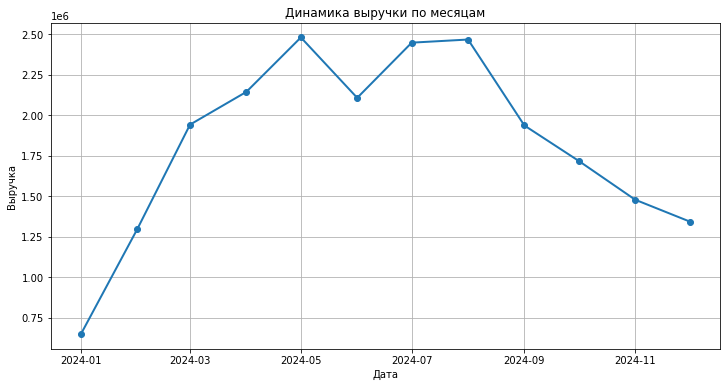

In [21]:
pa_marketplace_orders['marketplace_revenue'] = pa_marketplace_orders['total_price'] * 0.05

month_revenue = pa_marketplace_orders.groupby('order_month')['marketplace_revenue'].sum().reset_index()

plt.figure(figsize=(12,6))

plt.plot(month_revenue['order_month'], month_revenue['marketplace_revenue'], marker = 'o', linewidth = 2)

plt.title('Динамика выручки по месяцам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.show()

**По графику видно что выручка начала проседать с августа 24 года. Применим подход 'Дерева метрик'. Так мы и просто посмотри на динамику метрики и заодно узнаем где у нас могут скрываться проблемные места**

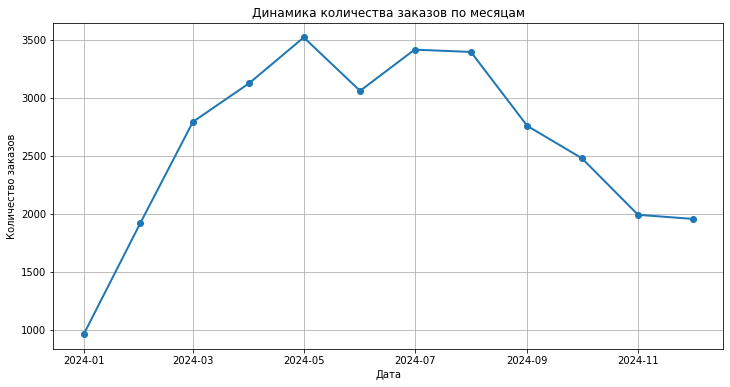

In [22]:
month_orders = pa_marketplace_orders.groupby('order_month')['order_id'].count().reset_index()

plt.figure(figsize=(12,6))

plt.plot(month_orders['order_month'], month_orders['order_id'], marker='o', linewidth = 2)

plt.title('Динамика количества заказов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

**Метрика имеет анологичное падение с августа месяца,заказов стало меньше соотвественно выручка стала падать.**

**Посмотри на что у нас со средним чеком,декомпозируя его от нижнеуровневых метрик**

Средняя цена предметов в заказе по месяцам:
2024-01: 6,766 руб.
2024-02: 6,734 руб.
2024-03: 6,882 руб.
2024-04: 6,868 руб.
2024-05: 7,086 руб.
2024-06: 6,933 руб.
2024-07: 7,138 руб.
2024-08: 7,228 руб.
2024-09: 6,971 руб.
2024-10: 6,867 руб.
2024-11: 7,289 руб.
2024-12: 6,837 руб.


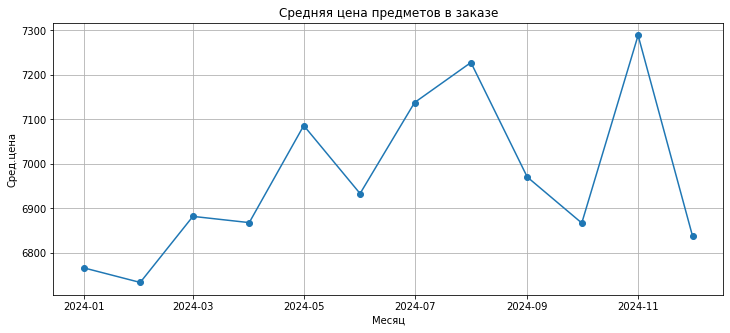

In [23]:
success_orders = pa_marketplace_orders.copy()

success_orders['month'] = pd.to_datetime(success_orders['order_date']).dt.to_period('M').dt.to_timestamp()

grouped_orders = success_orders.groupby('month').agg(
    price_sum=('total_price', 'sum'),
    item_quantity=('quantity', 'sum')
).reset_index()

grouped_orders['avg_item_price'] = grouped_orders['price_sum'] / grouped_orders['item_quantity']

print("Средняя цена предметов в заказе по месяцам:")
for idx, row in grouped_orders.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    print(f"{month_str}: {row['avg_item_price']:,.0f} руб.")

plt.figure(figsize=(12,5))
plt.plot(grouped_orders['month'], grouped_orders['avg_item_price'], marker='o')
plt.title('Средняя цена предметов в заказе')
plt.xlabel('Месяц')
plt.ylabel('Сред.цена')
plt.grid()
plt.show()

**Средняя цена товара колебалась в течение года в диапазоне 6,734 - 7,289 руб., но в целом оставалась стабильной на уровне 6.7-7.3 тыс. руб.**

Среднее количество товаров в заказе по месяцам:
2024-01: 1.99 товаров
2024-02: 2.01 товаров
2024-03: 2.02 товаров
2024-04: 2.00 товаров
2024-05: 1.99 товаров
2024-06: 1.99 товаров
2024-07: 2.01 товаров
2024-08: 2.01 товаров
2024-09: 2.01 товаров
2024-10: 2.02 товаров
2024-11: 2.04 товаров
2024-12: 2.01 товаров


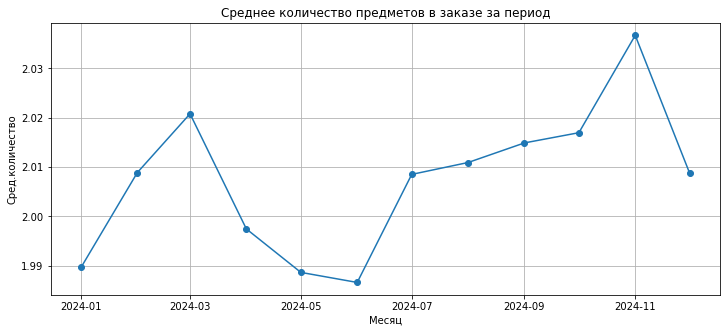

In [24]:
uccess_orders = pa_marketplace_orders.copy()

success_orders['month'] = pd.to_datetime(success_orders['order_date']).dt.to_period('M').dt.to_timestamp()

grouped_orders = success_orders.groupby('month').agg(
    order_quantity=('order_id', 'nunique'),  
    item_quantity=('quantity', 'sum')       
).reset_index()

grouped_orders['avg_item_count'] = grouped_orders['item_quantity'] / grouped_orders['order_quantity']

print("Среднее количество товаров в заказе по месяцам:")
for idx, row in grouped_orders.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    print(f"{month_str}: {row['avg_item_count']:.2f} товаров")

plt.figure(figsize=(12,5))
plt.plot(grouped_orders['month'], grouped_orders['avg_item_count'], marker='o')
plt.title('Среднее количество предметов в заказе за период')
plt.xlabel('Месяц')
plt.ylabel('Сред.количество')
plt.grid()
plt.show()

**В среднем количесвто товаров стабильно(около 2). По тренду видно как рост так и подение в течении года,но среднее количество стабильно.**

Средний чек (AOV) по месяцам:
2024-01: 13,462 руб.
2024-02: 13,527 руб.
2024-03: 13,907 руб.
2024-04: 13,719 руб.
2024-05: 14,092 руб.
2024-06: 13,774 руб.
2024-07: 14,337 руб.
2024-08: 14,535 руб.
2024-09: 14,045 руб.
2024-10: 13,851 руб.
2024-11: 14,845 руб.
2024-12: 13,734 руб.


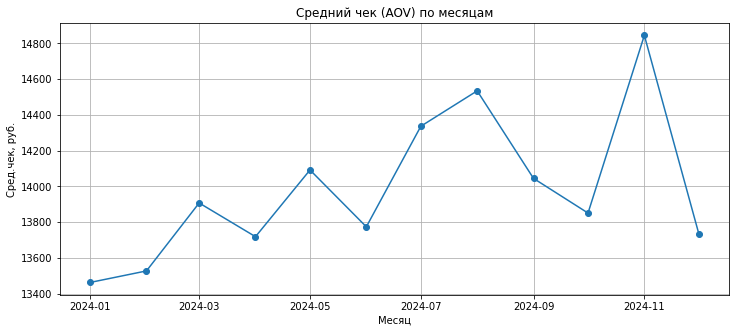

In [25]:
success_orders = pa_marketplace_orders.copy()

success_orders['month'] = pd.to_datetime(success_orders['order_date']).dt.to_period('M').dt.to_timestamp()

grouped_orders = success_orders.groupby('month').agg(
    order_quantity=('order_id', 'nunique'),      
    item_quantity=('quantity', 'sum'),           
    price_sum=('total_price', 'sum')          
).reset_index()

grouped_orders['avg_item_count'] = grouped_orders['item_quantity'] / grouped_orders['order_quantity']
grouped_orders['avg_item_price'] = grouped_orders['price_sum'] / grouped_orders['item_quantity']
grouped_orders['AOV'] = grouped_orders['avg_item_price'] * grouped_orders['avg_item_count']

print("Средний чек (AOV) по месяцам:")
for idx, row in grouped_orders.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    print(f"{month_str}: {row['AOV']:,.0f} руб.")

plt.figure(figsize=(12,5))
plt.plot(grouped_orders['month'], grouped_orders['AOV'], marker='o')
plt.title('Средний чек (AOV) по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сред.чек, руб.')
plt.grid()
plt.show()

**Средний чек с начала года стабильно рос,но с августа по октябрь просел.После в ноябре резко вырос и снова просел в декабре.**

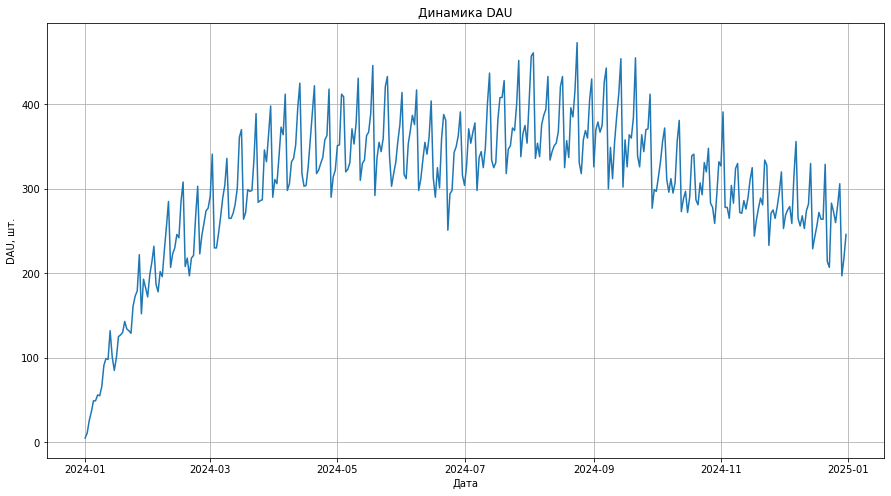

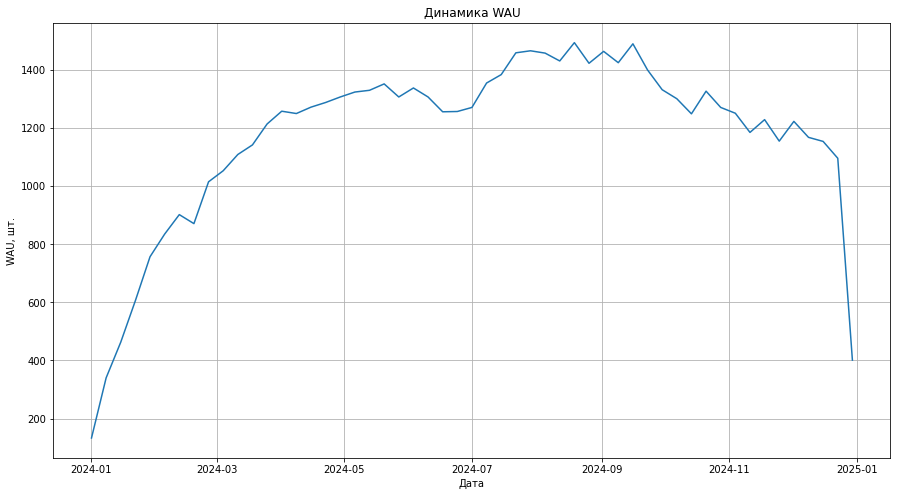

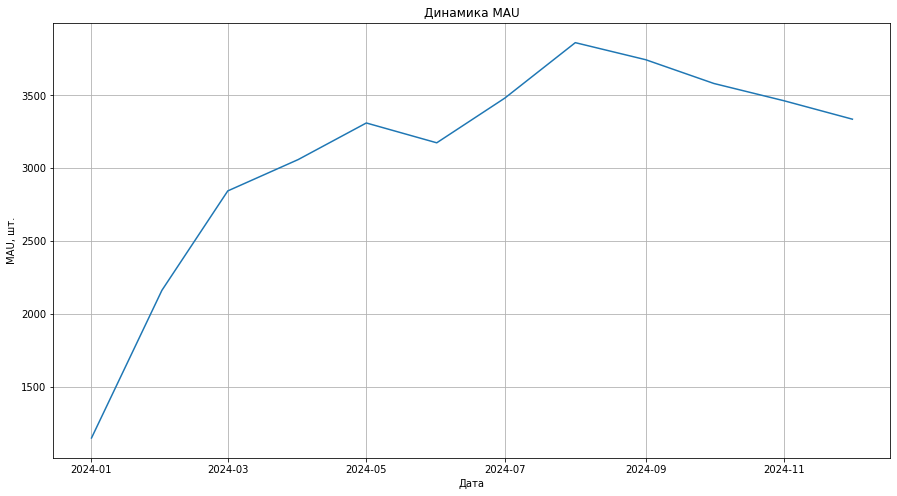

In [26]:
DAU = pa_marketplace_events.groupby('event_date')['user_id'].nunique().reset_index()
WAU = pa_marketplace_events.groupby('event_week')['user_id'].nunique().reset_index()
MAU = pa_marketplace_events.groupby('event_month')['user_id'].nunique().reset_index()


plt.figure(figsize=(15,8))

plt.plot(DAU['event_date'], DAU['user_id'])

plt.title("Динамика DAU")
plt.xlabel("Дата") 
plt.ylabel("DAU, шт.")
plt.grid()

plt.figure(figsize=(15,8))

plt.plot(WAU['event_week'], WAU['user_id'])

plt.title("Динамика WAU")
plt.xlabel("Дата") 
plt.ylabel("WAU, шт.")
plt.grid()

plt.figure(figsize=(15,8))

plt.plot(MAU['event_month'], MAU['user_id'])

plt.title("Динамика MAU")
plt.xlabel("Дата") 
plt.ylabel("MAU, шт.")
plt.grid()

plt.show()

**С августа месяца активных пользователей становится меньше.Продукт стал менее интересен пользователям**

,step,users,conversion_from_first_%,conversion_from_previous_%
0,page_view,22098,100.0,NaN
1,product_view,22069,99.9,99.9
2,add_to_cart,20411,92.4,92.5
3,checkout_start,16769,75.9,82.2
4,checkout_complete,13897,62.9,82.9
5,actual_purchase,8922,40.4,64.2


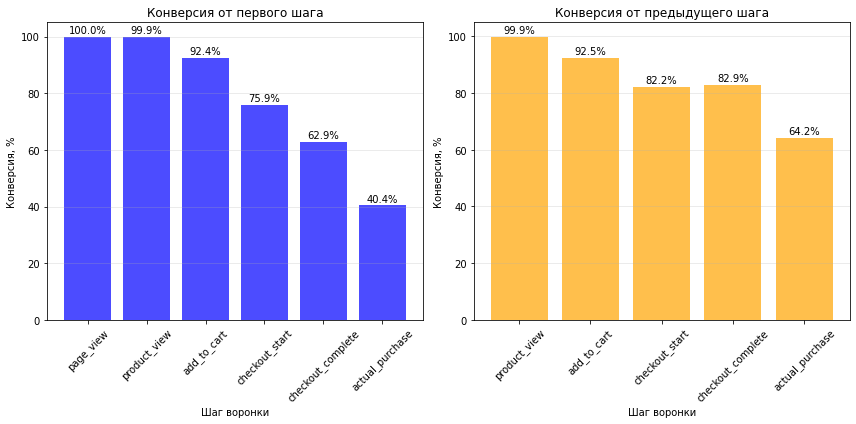

In [27]:
funnel_steps = ['page_view', 'product_view', 'add_to_cart', 'checkout_start', 'checkout_complete', 'actual_purchase']
funnel_data = []

page_view_users = pa_marketplace_events[pa_marketplace_events['event_type'] == 'page_view']['user_id'].nunique()

product_view_users = pa_marketplace_events[pa_marketplace_events['event_type'] == 'product_view']['user_id'].nunique()

add_to_cart_users = pa_marketplace_events[pa_marketplace_events['event_type'] == 'add_to_cart']['user_id'].nunique()

checkout_start_users = pa_marketplace_events[pa_marketplace_events['event_type'] == 'checkout_start']['user_id'].nunique()

checkout_complete_users = pa_marketplace_events[pa_marketplace_events['event_type'] == 'checkout_complete']['user_id'].nunique()

actual_purchase_users = pa_marketplace_orders['user_id'].nunique()

funnel_data.append(['page_view', page_view_users])
funnel_data.append(['product_view', product_view_users])
funnel_data.append(['add_to_cart', add_to_cart_users])
funnel_data.append(['checkout_start', checkout_start_users])
funnel_data.append(['checkout_complete', checkout_complete_users])
funnel_data.append(['actual_purchase', actual_purchase_users])

funnel_df = pd.DataFrame(funnel_data, columns=['step', 'users'])

funnel_df['conversion_from_first_%'] = (funnel_df['users'] / funnel_df['users'].iloc[0] * 100).round(1)
funnel_df['conversion_from_previous_%'] = (funnel_df['users'] / funnel_df['users'].shift(1) * 100).round(1)

display(funnel_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

x_positions = np.arange(len(funnel_df['step']))
y_values1 = funnel_df['conversion_from_first_%'].values

bars1 = axes[0].bar(funnel_df['step'], funnel_df['conversion_from_first_%'], color='blue', alpha=0.7)
axes[0].set_title('Конверсия от первого шага')
axes[0].set_ylabel('Конверсия, %')
axes[0].set_xlabel('Шаг воронки')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

for x, y in zip(x_positions, y_values1):
    axes[0].text(x, y + 0.5, f'{y}%', ha='center', va='bottom', fontsize=10)
    
x_positions2 = np.arange(len(funnel_df['step'].iloc[1:]))
y_values2 = funnel_df['conversion_from_previous_%'].iloc[1:].values

bars2 = axes[1].bar(funnel_df['step'].iloc[1:], funnel_df['conversion_from_previous_%'].iloc[1:], color='orange', alpha=0.7)
axes[1].set_title('Конверсия от предыдущего шага')
axes[1].set_ylabel('Конверсия, %')
axes[1].set_xlabel('Шаг воронки')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

for x, y in zip(x_positions2, y_values2):
    axes[1].text(x, y + 0.5, f'{y}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Видим перву проблемную зону,это переход от add_to_cart к checkout_start, а также падение конверсии в финальноую оплату покупки(actual_purchase)**

**Помотрим как продукт удерживает пользователей**

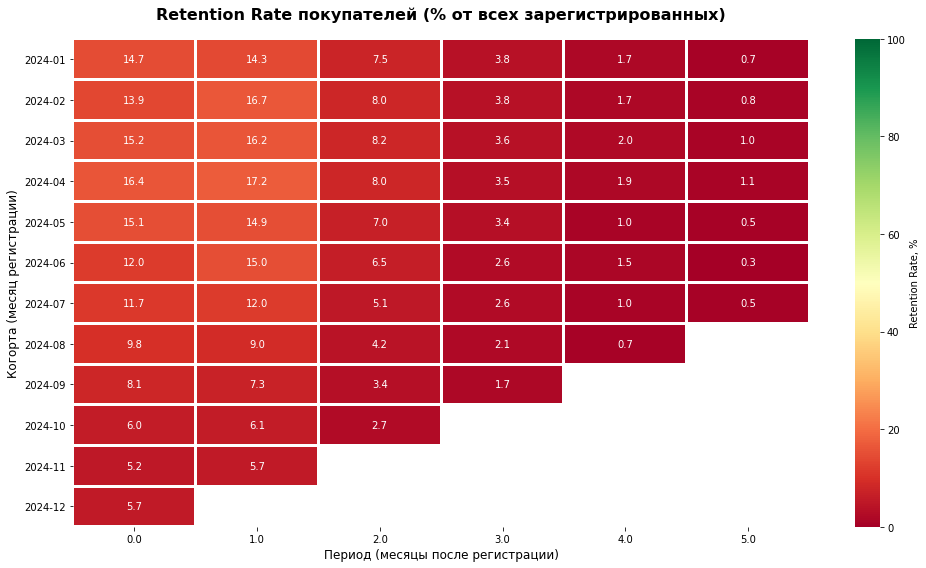

In [28]:
cohort_sizes = pa_marketplace_users.groupby('cohort_month')['user_id'].nunique()

buyers_cohort = pa_marketplace_orders.merge(
    pa_marketplace_users[['user_id', 'cohort_month']],
    on='user_id',
    how='left'
)[['user_id', 'cohort_month', 'order_month']].drop_duplicates()

buyers_cohort['cohort_month'] = pd.to_datetime(buyers_cohort['cohort_month'])
buyers_cohort['order_month'] = pd.to_datetime(buyers_cohort['order_month'])

buyers_cohort['n_period'] = (
    (buyers_cohort['order_month'].dt.year - buyers_cohort['cohort_month'].dt.year) * 12 +
    (buyers_cohort['order_month'].dt.month - buyers_cohort['cohort_month'].dt.month)
)

buyers_pivot = buyers_cohort.pivot_table(
    index='cohort_month',
    columns='n_period',
    values='user_id',
    aggfunc='nunique'
).fillna(0)

buyers_retention = (buyers_pivot.div(cohort_sizes, axis=0) * 100).round(1)

buyers_display = buyers_retention.replace(0, np.nan)
buyers_display.index = buyers_display.index.strftime('%Y-%m')
available_cohorts = buyers_display.index.tolist()
buyers_display = buyers_display.iloc[:, :min(6, len(buyers_display.columns))]

plt.figure(figsize=(14, 8))

sns.heatmap(
    buyers_display,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    linewidths=2,
    linecolor='white',
    annot_kws={'size': 10},
    vmin=0,
    vmax=100,
    mask=buyers_display.isna(),
    cbar_kws={'label': 'Retention Rate, %'}
)

plt.title('Retention Rate покупателей (% от всех зарегистрированных)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Период (месяцы после регистрации)', fontsize=12)
plt.ylabel('Когорта (месяц регистрации)', fontsize=12)

plt.tight_layout()
plt.show()

**Удержание покупателей критически низкое — лишь 23-43% зарегистрированных совершают первую покупку, причем этот показатель систематически ухудшается в течение года (с 39.8% в январе до 23.6% в декабре), а к 6-му месяцу остается лишь 1-2% пользователей.**

**Промежутоный вывод**

**Применив подход 'Дерева метрик' и декомпозируя метрики на уровни уже на этапе простого знакомства с состоянием бизнеса увидели проблемные места**

**У бизнеса падает выручка,копнув дальше понимаем что падение связано с уменьшением каличества заказов. Идём дальше и обноруживаем что у нас так же упало количество активных пользователей и есть проблемные этапы в конверсии от простмотра до покупки. Все эти проблемы начались с августа месяца,стоит узнать что происходило в продукте в данное время,а пока продолжим изучение данных и оценим метрики монетизации и юнит экономики**

**Так же у продукта крайне низкое удержание пользоватьелей**

**Более точные итоговые выводы опишем в специальном блоке для вывода этапов 2 и 3**

### 3. Оценка метрик монетизации и юнит-экономики

Выполните анализ монетизации. Определите, сколько зарабатывает продукт и сколько тратит на привлечение.

Важны как агрегированные метрики (ARPU, AOV), так и показатели эффективности (CAC, ROI, Payback Period).

Сформулируйте первые выводы по результатам анализа метрик. Сделайте это в формате записки для заказчика. Изложите все основные результаты так, чтобы прослеживалась связь между мыслями. Не пишите много — заказчик не будет читать записку полностью, а просто просмотрит.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.

ARPU за весь период 2024:
  Общая выручка: 21,997,211 руб.
  Активных пользователей (покупатели): 8,922
  ARPU = 2,466 руб.

2024-01: 1,429 руб. (Выручка: 648,890 руб., Активных: 454)
2024-02: 1,545 руб. (Выручка: 1,296,557 руб., Активных: 839)
2024-03: 1,666 руб. (Выручка: 1,940,750 руб., Активных: 1,165)
2024-04: 1,618 руб. (Выручка: 2,142,838 руб., Активных: 1,324)
2024-05: 1,765 руб. (Выручка: 2,478,758 руб., Активных: 1,404)
2024-06: 1,712 руб. (Выручка: 2,106,012 руб., Активных: 1,230)
2024-07: 1,766 руб. (Выручка: 2,446,535 руб., Активных: 1,385)
2024-08: 1,780 руб. (Выручка: 2,465,802 руб., Активных: 1,385)
2024-09: 1,664 руб. (Выручка: 1,935,367 руб., Активных: 1,163)
2024-10: 1,718 руб. (Выручка: 1,716,108 руб., Активных: 999)
2024-11: 1,744 руб. (Выручка: 1,477,100 руб., Активных: 847)
2024-12: 1,672 руб. (Выручка: 1,342,492 руб., Активных: 803)


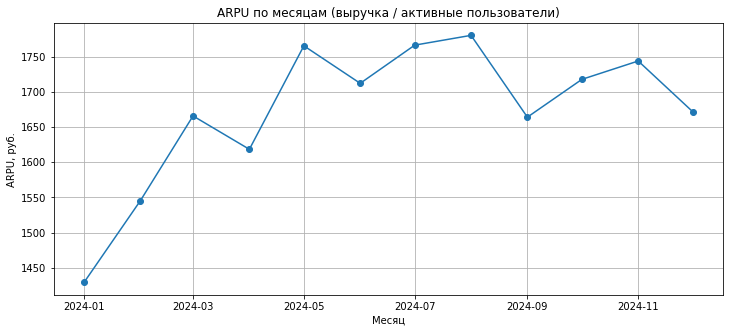

In [29]:
success_orders = pa_marketplace_orders.copy()
success_orders['marketplace_revenue'] = success_orders['total_price'] * 0.05

active_users_count = success_orders['user_id'].nunique()

total_revenue = success_orders['marketplace_revenue'].sum()

arpu_total = total_revenue / active_users_count

print(f"ARPU за весь период 2024:")
print(f"  Общая выручка: {total_revenue:,.0f} руб.")
print(f"  Активных пользователей (покупатели): {active_users_count:,}")
print(f"  ARPU = {arpu_total:,.0f} руб.")
print()

success_orders['month'] = pd.to_datetime(success_orders['order_date']).dt.to_period('M').dt.to_timestamp()

monthly_stats = success_orders.groupby('month').agg(
    revenue_sum=('marketplace_revenue', 'sum'),
    active_users=('user_id', 'nunique')
).reset_index()

monthly_stats['ARPU'] = monthly_stats['revenue_sum'] / monthly_stats['active_users']

for idx, row in monthly_stats.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    print(f"{month_str}: {row['ARPU']:,.0f} руб. "
          f"(Выручка: {row['revenue_sum']:,.0f} руб., "
          f"Активных: {row['active_users']:,})")

plt.figure(figsize=(12,5))
plt.plot(monthly_stats['month'], monthly_stats['ARPU'], marker='o')
plt.title('ARPU по месяцам (выручка / активные пользователи)')
plt.xlabel('Месяц')
plt.ylabel('ARPU, руб.')
plt.grid()
plt.show()

Средний чек (AOV) по месяцам:
2024-01: 13,462 руб.
2024-02: 13,527 руб.
2024-03: 13,907 руб.
2024-04: 13,719 руб.
2024-05: 14,092 руб.
2024-06: 13,774 руб.
2024-07: 14,337 руб.
2024-08: 14,535 руб.
2024-09: 14,045 руб.
2024-10: 13,851 руб.
2024-11: 14,845 руб.
2024-12: 13,734 руб.


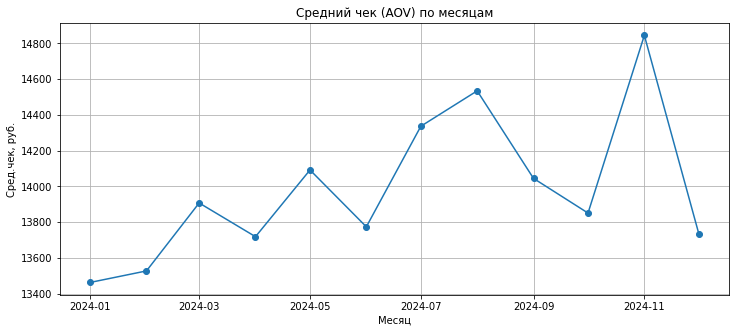

In [30]:
success_orders = pa_marketplace_orders.copy()

success_orders['month'] = pd.to_datetime(success_orders['order_date']).dt.to_period('M').dt.to_timestamp()

grouped_orders = success_orders.groupby('month').agg(
    order_quantity=('order_id', 'nunique'),      
    item_quantity=('quantity', 'sum'),           
    price_sum=('total_price', 'sum')          
).reset_index()

grouped_orders['avg_item_count'] = grouped_orders['item_quantity'] / grouped_orders['order_quantity']
grouped_orders['avg_item_price'] = grouped_orders['price_sum'] / grouped_orders['item_quantity']
grouped_orders['AOV'] = grouped_orders['avg_item_price'] * grouped_orders['avg_item_count']

print("Средний чек (AOV) по месяцам:")
for idx, row in grouped_orders.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    print(f"{month_str}: {row['AOV']:,.0f} руб.")

plt.figure(figsize=(12,5))
plt.plot(grouped_orders['month'], grouped_orders['AOV'], marker='o')
plt.title('Средний чек (AOV) по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сред.чек, руб.')
plt.grid()
plt.show()

**Средний чек с начала года стабильно рос,но с августа по октябрь просел.После в ноябре резко вырос и снова просел в декабре.**

**Метрика демонстрировала стабильный рост с января по август (с 1,429 до 1,780, +24.6%), после чего начала стабилизироваться,есть как и подение так и рост,метрика колеблится. При этом ключевой проблемой остается не ARPU, а существенное сокращение количества активных покупателей, выявленное ранее в анализе DAU/WAU/MAU.**

1. ОБЩИЙ CAC:
   Всего расходов на маркетинг: 19,327,168 руб.
   Всего привлечено пользователей: 44,151
   CAC = 438 руб.

2024-01: 394 руб. (Расходы: 1,177,457 руб., Новых: 2,985)
2024-02: 392 руб. (Расходы: 1,061,386 руб., Новых: 2,711)
2024-03: 394 руб. (Расходы: 1,167,680 руб., Новых: 2,965)
2024-04: 395 руб. (Расходы: 1,147,740 руб., Новых: 2,905)
2024-05: 400 руб. (Расходы: 1,225,322 руб., Новых: 3,066)
2024-06: 402 руб. (Расходы: 1,130,440 руб., Новых: 2,810)
2024-07: 405 руб. (Расходы: 1,776,447 руб., Новых: 4,388)
2024-08: 409 руб. (Расходы: 1,811,678 руб., Новых: 4,431)
2024-09: 408 руб. (Расходы: 1,820,719 руб., Новых: 4,466)
2024-10: 408 руб. (Расходы: 1,810,803 руб., Новых: 4,440)
2024-11: 405 руб. (Расходы: 1,773,970 руб., Новых: 4,383)
2024-12: 404 руб. (Расходы: 1,858,570 руб., Новых: 4,601)


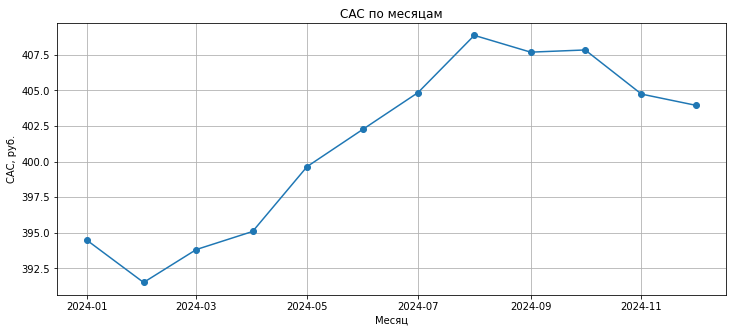

In [31]:
total_marketing_spend = pa_marketplace_campaign_costs_redact['budget'].sum()

total_users = pa_marketplace_users['user_id'].nunique()

overall_cac = total_marketing_spend / total_users

print(f"1. ОБЩИЙ CAC:")
print(f"   Всего расходов на маркетинг: {total_marketing_spend:,.0f} руб.")
print(f"   Всего привлечено пользователей: {total_users:,}")
print(f"   CAC = {overall_cac:,.0f} руб.")
print()

all_users = pa_marketplace_users.copy()
all_users['month'] = pd.to_datetime(all_users['registration_date']).dt.to_period('M').dt.to_timestamp()

monthly_new_users = all_users.groupby('month').agg(
    new_users=('user_id', 'count')
).reset_index()

monthly_marketing = pa_marketplace_campaign_costs_redact.groupby('spend_month').agg(
    marketing_spend=('budget', 'sum')
).reset_index()

cac_monthly = monthly_new_users.merge(
    monthly_marketing, 
    left_on='month', 
    right_on='spend_month',
    how='left'
)

cac_monthly['CAC'] = cac_monthly['marketing_spend'] / cac_monthly['new_users']

for idx, row in cac_monthly.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    if pd.notna(row['CAC']):
        print(f"{month_str}: {row['CAC']:,.0f} руб. "
              f"(Расходы: {row['marketing_spend']:,.0f} руб., "
              f"Новых: {row['new_users']:,})")

plt.figure(figsize=(12,5))
plt.plot(cac_monthly['month'], cac_monthly['CAC'], marker='o')
plt.title('CAC по месяцам')
plt.xlabel('Месяц')
plt.ylabel('CAC, руб.')
plt.grid()
plt.show()

**Расходы с февараля стабильно росли,но с августа тренд пошёл вниз.Возиожно это связано с уменьшением активностей пользователей.Бюджет сократился на рекламу,или новые маркетинговые компании оказались более дешёвыми и в тоже время стали хуже привлекать и удерживать пользователей.**

2024-01: -44.9% (Доход: 648,890 руб., Затраты: 1,177,457 руб.)
2024-02: +22.2% (Доход: 1,296,557 руб., Затраты: 1,061,386 руб.)
2024-03: +66.2% (Доход: 1,940,750 руб., Затраты: 1,167,680 руб.)
2024-04: +86.7% (Доход: 2,142,838 руб., Затраты: 1,147,740 руб.)
2024-05: +102.3% (Доход: 2,478,758 руб., Затраты: 1,225,322 руб.)
2024-06: +86.3% (Доход: 2,106,012 руб., Затраты: 1,130,440 руб.)
2024-07: +37.7% (Доход: 2,446,535 руб., Затраты: 1,776,447 руб.)
2024-08: +36.1% (Доход: 2,465,802 руб., Затраты: 1,811,678 руб.)
2024-09: +6.3% (Доход: 1,935,367 руб., Затраты: 1,820,719 руб.)
2024-10: -5.2% (Доход: 1,716,108 руб., Затраты: 1,810,803 руб.)
2024-11: -16.7% (Доход: 1,477,100 руб., Затраты: 1,773,970 руб.)
2024-12: -27.8% (Доход: 1,342,492 руб., Затраты: 1,858,570 руб.)


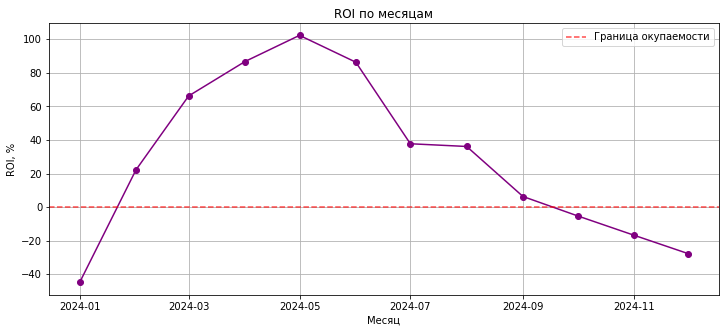

In [32]:
roi_simple = cac_monthly.copy()
roi_simple = roi_simple.merge(monthly_stats[['month', 'revenue_sum']], on='month', how='left')
roi_simple.rename(columns={'revenue_sum': 'monthly_revenue'}, inplace=True)

roi_simple['ROI_simple'] = (roi_simple['monthly_revenue'] - roi_simple['marketing_spend']) / roi_simple['marketing_spend'] * 100

for idx, row in roi_simple.iterrows():
    month_str = row['month'].strftime('%Y-%m')
    if pd.notna(row['ROI_simple']):
        print(f"{month_str}: {row['ROI_simple']:+.1f}% "
              f"(Доход: {row['monthly_revenue']:,.0f} руб., "
              f"Затраты: {row['marketing_spend']:,.0f} руб.)")

plt.figure(figsize=(12,5))
plt.plot(roi_simple['month'], roi_simple['ROI_simple'], marker='o', color='purple')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Граница окупаемости')
plt.title('ROI по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ROI, %')
plt.grid()
plt.legend()
plt.show()

**До мая ROI стабильно рос,после чего тренд начал падать. В июле по август тренд начал стабилизироваться но с падением метрик выручки,активных пользователей в августе,вместе с ним упал и показатель ROI**

Средний LTV = 484 руб.
• Всего пользователей: 44,151
• Покупателей: 8,922 (20.2%)
• Общая выручка: 21,997,211 руб.
  2024-01: 705 руб.
  2024-02: 757 руб.
  2024-03: 837 руб.
  2024-04: 846 руб.
  2024-05: 733 руб.
  2024-06: 673 руб.
  2024-07: 565 руб.
  2024-08: 425 руб.
  2024-09: 324 руб.
  2024-10: 249 руб.
  2024-11: 183 руб.
  2024-12: 85 руб.


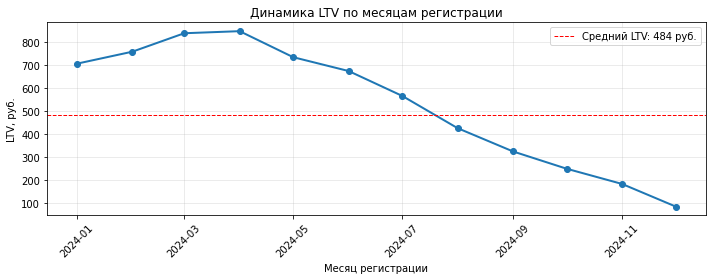

In [33]:
user_revenue = pa_marketplace_orders.groupby('user_id')['marketplace_revenue'].sum()

all_users = pa_marketplace_users['user_id'].unique()

user_revenue_all = pd.Series(0, index=all_users)
user_revenue_all.update(user_revenue)

ltv_correct = user_revenue_all.mean()

print(f"Средний LTV = {ltv_correct:.0f} руб.")
print(f"• Всего пользователей: {len(all_users):,}")
print(f"• Покупателей: {len(user_revenue):,} ({len(user_revenue)/len(all_users)*100:.1f}%)")
print(f"• Общая выручка: {user_revenue.sum():,.0f} руб.")

users_with_cohort = pa_marketplace_users[['user_id', 'registration_date']].copy()
users_with_cohort['reg_month'] = users_with_cohort['registration_date'].dt.strftime('%Y-%m')

user_revenue_df = user_revenue_all.reset_index()
user_revenue_df.columns = ['user_id', 'marketplace_revenue']
user_data = users_with_cohort.merge(user_revenue_df, on='user_id', how='left')

ltv_by_cohort = user_data.groupby('reg_month')['marketplace_revenue'].mean().round(0)

for month, ltv_value in ltv_by_cohort.items():
    print(f"  {month}: {ltv_value:,.0f} руб.")

plt.figure(figsize=(10, 4))

ltv_by_cohort.index = pd.to_datetime(ltv_by_cohort.index)
ltv_by_cohort = ltv_by_cohort.sort_index()

plt.plot(ltv_by_cohort.index, ltv_by_cohort.values, marker='o', linewidth=2)
plt.axhline(y=ltv_correct, color='red', linestyle='--', linewidth=1, 
           label=f'Средний LTV: {ltv_correct:.0f} руб.')
plt.title('Динамика LTV по месяцам регистрации', fontsize=12)
plt.xlabel('Месяц регистрации', fontsize=10)
plt.ylabel('LTV, руб.', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**LTV стабильнео падает с апреля месяца**

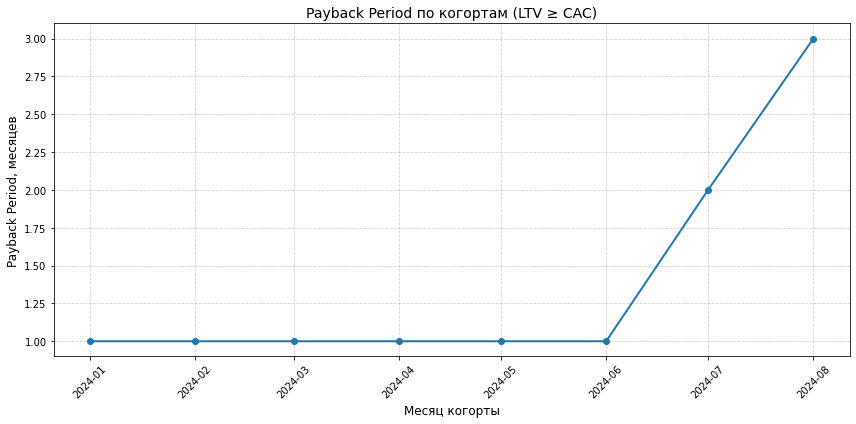

In [34]:
orders_cohort = pa_marketplace_orders.merge(
    pa_marketplace_users[['user_id', 'cohort_month']],
    on='user_id',
    how='left'
)

orders_cohort['cohort_age'] = (
    (orders_cohort['order_month'].dt.year - orders_cohort['cohort_month'].dt.year) * 12 +
    (orders_cohort['order_month'].dt.month - orders_cohort['cohort_month'].dt.month)
)

orders_cohort['Revenue'] = orders_cohort['total_price'] * 0.05

ltv = (
    orders_cohort
    .groupby(['cohort_month', 'cohort_age'], as_index=False)
    .agg(Revenue=('Revenue', 'sum'))
)

cohort_size = (
    pa_marketplace_users
    .groupby('cohort_month', as_index=False)
    .agg(Cohort_Size=('user_id', 'nunique'))
)

ltv = ltv.merge(cohort_size, on='cohort_month', how='left')
ltv['LTV'] = ltv['Revenue'] / ltv['Cohort_Size']

ltv = ltv.sort_values(['cohort_month', 'cohort_age'])

ltv['Cum_LTV'] = (
    ltv
    .groupby('cohort_month')['LTV']
    .cumsum()
)

cac_by_cohort = pa_marketplace_campaign_costs_redact.copy()
cac_by_cohort['cohort_month'] = cac_by_cohort['spend_month']
cac_by_cohort = cac_by_cohort.groupby('cohort_month')['budget'].sum().reset_index()
cac_by_cohort = cac_by_cohort.merge(cohort_size, on='cohort_month', how='left')
cac_by_cohort['CAC'] = cac_by_cohort['budget'] / cac_by_cohort['Cohort_Size']

ltv = ltv.merge(
    cac_by_cohort[['cohort_month', 'CAC']],
    on='cohort_month',
    how='left'
)

payback = (
    ltv[ltv['cohort_age'] >= 1]  
    .query('Cum_LTV >= CAC')
    .groupby('cohort_month', as_index=False)
    .agg(Payback_Period=('cohort_age', 'min'))
)

plt.figure(figsize=(12, 6))
plt.plot(
    payback['cohort_month'],
    payback['Payback_Period'],
    marker='o',
    linewidth=2
)

plt.title('Payback Period по когортам (LTV ≥ CAC)', fontsize=14)
plt.xlabel('Месяц когорты', fontsize=12)
plt.ylabel('Payback Period, месяцев', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Срок окупаемости растёт с 1 до 3 месяцев, что сигнализирует об ухудшении экономики новых пользователей**

## Выводы по этапам 2 и 3


Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

**Посмотрев на продукт видно что проблемы начались с августа 2024г.**

- Выручка упала на 45% с июля по декабрь (с 2.45 млн до 1.34 млн руб.)

- Количество активных покупателей сократилось на 42% (с 1,385 до 803 человек)

- ROI маркетинга стал отрицательным (-28% в декабре против +102% в мае)

**Построив воронку нам удалось найти проблемные места в которых у пользователей возникают трудности,и продукт теряет клиентов. Конверсия регистраций в покупки критически низкая - 20.2% (только каждый 5-й зарегистрированный становится покупателем), при этом воронка показывает потерю 18% на этапе 'корзина - оформление' и 36% на 'оформление - оплата'.**

**Построив метрики активных пользователей DAU/WAU/MAU так же фиксируем потерю интереса у пользователей к продукту с августа месяца 2024г.**

**Удержание клиентов у продукта тоже крайне низкое. Только 23-43% новых пользователей совершают первую покупку, к 6-му месяцу остается 1-2%**

**Оценка метрик монетизации и юнит-экономики выявляет системные проблемы, начавшиеся также в августе 2024:**

- ARPU показывает положительную динамику с января по август (с 1,429 до 1,780 руб., +24.6%), но после августа стабилизируется с колебаниями

- CAC остаётся стабильным (~400 руб.) с небольшим ростом к середине года

- ROI, достигнув пика в мае (+102%), к декабрю стал отрицательным (-28%)

- LTV (доход с привлечённого пользователя) составляет 484 руб. и демонстрирует негативную динамику - падает с 846 руб. (апрель) до 85 руб. (декабрь)

- Payback Period по когортному анализу: в среднем 1.4 месяца, но растёт с 1 месяца для ранних когорт до 3 месяцев для августовской когорты

**Ключевая проблема - 
1)Ухудшение качества трафика: новые пользователи приносят всё меньше дохода при стабильной стоимости привлечения. LTV/CAC = 1.1 показывает, что бизнес едва окупает затраты на привлечение.**
**2)Отток активных пользователей,проблемы выявленые на этапе помтсроения воронки**

**Рекомендации:**

- Исследовать причины падения активности с августа 2024 (Что происходило в продукте в этот период? Какие акции проводились и с какими техническими проблемами мог столкнуться продукт?)

- Сфокусироваться на повышении конверсии в покупки, особенно на этапах "корзина → оформление" и "оформление → оплата" (Прочитать отзывы пользователей, найти инсайты и разработать стратегию для улучшения этих этапов)

- Улучшить удержание новых пользователей через программы лояльности и персонализированные предложения

- Перераспределить маркетинговый бюджет с неэффективных каналов (TikTok, ROI -90.6%) на эффективные (Affiliate, ROI +234.7%)

## 4. Поиск инсайтов, точек роста и сегментация


После того как вы провели верхнеуровневую оценку данных, самое время переходить от общей картины к точечным наблюдениям. Посмотрите вглубь данных: по каналам,
сегментам пользователей, категориям товаров, регионам, типам устройств. Ищите
закономерности, различия, аномалии.

Цель — сформировать обоснованные гипотезы:

* какие сегменты работают лучше остальных
* какие сегменты работают хуже остальных
* на каких этапах воронки теряются пользователи
* какие группы можно или нужно масштабировать
* куда стоит инвестировать больше внимания или ресурсов

По итогам анализа также:

* сформулируйте в виде аналитической записки выводы
* сформулируйте несколько гипотез, которые помогут развить продукт. Например: «Если предлагать клиентам на iOS персонализированные скидки, то они станут чаще конвертировать в продукт». При формулировании гипотез опишите, на что вы опираетесь при её формировании. Например, на динамику метрики или на взаимосвязь метрик.

Напишите выводы в конце блока, чтобы заказчик мог быстро ознакомиться с основными результатами.
Отправьте работу на проверку ревьюеру. Ревьюер будет проверять корректность выводов и гипотез, а не сам код расчета, поэтому проверьте, что у вас есть выводы по каждому из блоков в предназначенном для этого месте.
После завершения ревью вы получите от ревьюера новые вводные и задачу от бизнеса.



Канал: Affiliate
  Пользователей: 6,069
  Из них купили: 2,338 (38.5%)
  Выручка: 6,735,815 руб.
  ARPU: 2,881 руб.
  Затраты на рекламу: 2,012,341 руб.
  CAC: 332 руб.
  ROI: +234.7%

Канал: SEO
  Пользователей: 3,312
  Из них купили: 874 (26.4%)
  Выручка: 1,909,935 руб.
  ARPU: 2,185 руб.
  Затраты на рекламу: 661,512 руб.
  CAC: 200 руб.
  ROI: +188.7%

Канал: Social Media
  Пользователей: 4,179
  Из них купили: 1,211 (29.0%)
  Выручка: 3,000,255 руб.
  ARPU: 2,478 руб.
  Затраты на рекламу: 1,647,396 руб.
  CAC: 394 руб.
  ROI: +82.1%

Канал: Google Ads
  Пользователей: 9,319
  Из них купили: 3,187 (34.2%)
  Выручка: 8,236,760 руб.
  ARPU: 2,584 руб.
  Затраты на рекламу: 4,663,490 руб.
  CAC: 500 руб.
  ROI: +76.6%

Канал: Email Marketing
  Пользователей: 2,044
  Из них купили: 325 (15.9%)
  Выручка: 555,699 руб.
  ARPU: 1,710 руб.
  Затраты на рекламу: 538,342 руб.
  CAC: 263 руб.
  ROI: +3.2%

Канал: TikTok
  Пользователей: 19,228
  Из них купили: 719 (3.7%)
  Выручка: 910,448

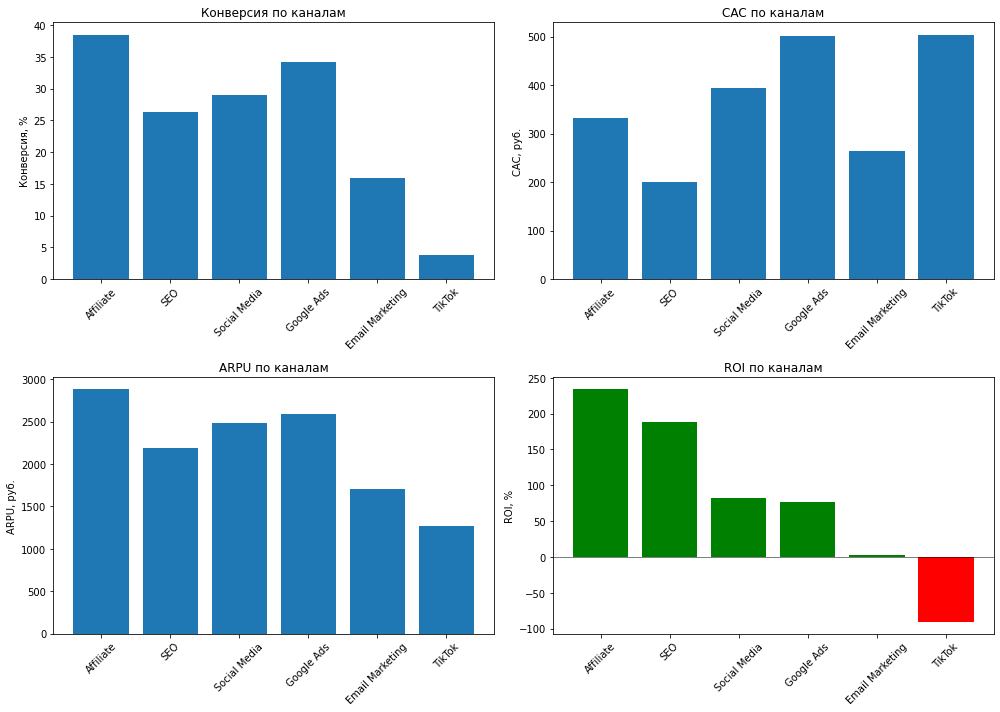

In [35]:
channel_stats = pa_marketplace_users.groupby('acq_channel').agg(
    users=('user_id', 'nunique')
).reset_index()

paying_stats = pa_marketplace_orders.merge(
    pa_marketplace_users[['user_id', 'acq_channel']],
    on='user_id'
).groupby('acq_channel').agg(
    paying=('user_id', 'nunique'),
    revenue=('marketplace_revenue', 'sum')
).reset_index()

channel_stats = channel_stats.merge(paying_stats, on='acq_channel', how='left')

costs = pa_marketplace_campaign_costs_redact.groupby('acq_channel').agg(
    budget=('budget', 'sum')
).reset_index()

channel_stats = channel_stats.merge(costs, on='acq_channel', how='left')

channel_stats['conversion'] = channel_stats['paying'] / channel_stats['users'] * 100
channel_stats['CAC'] = channel_stats['budget'] / channel_stats['users']
channel_stats['ARPU'] = channel_stats['revenue'] / channel_stats['paying']
channel_stats['effective_rev'] = channel_stats['ARPU'] * (channel_stats['conversion'] / 100)
channel_stats['ROI'] = (channel_stats['effective_rev'] - channel_stats['CAC']) / channel_stats['CAC'] * 100

channel_stats = channel_stats.sort_values('ROI', ascending=False)
    
def print_channel_stats(row):
    print(f"\nКанал: {row['acq_channel']}")
    print(f"  Пользователей: {row['users']:,}")
    print(f"  Из них купили: {row['paying']:,} ({row['conversion']:.1f}%)")
    print(f"  Выручка: {row['revenue']:,.0f} руб.")
    print(f"  ARPU: {row['ARPU']:,.0f} руб.")
    print(f"  Затраты на рекламу: {row['budget']:,.0f} руб.")
    print(f"  CAC: {row['CAC']:.0f} руб.")
    print(f"  ROI: {row['ROI']:+.1f}%")
    return None

channel_stats.apply(print_channel_stats, axis=1)
    
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].bar(channel_stats['acq_channel'], channel_stats['conversion'])
axes[0, 0].set_title('Конверсия по каналам')
axes[0, 0].set_ylabel('Конверсия, %')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(channel_stats['acq_channel'], channel_stats['CAC'])
axes[0, 1].set_title('CAC по каналам')
axes[0, 1].set_ylabel('CAC, руб.')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(channel_stats['acq_channel'], channel_stats['ARPU'])
axes[1, 0].set_title('ARPU по каналам')
axes[1, 0].set_ylabel('ARPU, руб.')
axes[1, 0].tick_params(axis='x', rotation=45)

colors = ['green' if x > 0 else 'red' for x in channel_stats['ROI']]
axes[1, 1].bar(channel_stats['acq_channel'], channel_stats['ROI'], color=colors)
axes[1, 1].set_title('ROI по каналам')
axes[1, 1].set_ylabel('ROI, %')
axes[1, 1].axhline(y=0, color='black', linewidth=0.5)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Посмотрев на данные по каналам привлечения видим что TikTok является убыточным каналом.При больших вложений на маркетинг у канала карйне низкиое ROI и ARPU.ТАк же на грани убыточности находится канал Email MArketing**

Анализ по сегментам покупателей:
               users  buyers  avg_orders  avg_revenue  conversion
buyer_segment                                                    
medium         16421  3692.0        0.46       316.09   22.483405
one_time        6701   258.0        0.05        32.99    3.850172
rare           13256   988.0        0.11        78.98    7.453229
regular         7773  3716.0        2.71      1915.66   47.806510


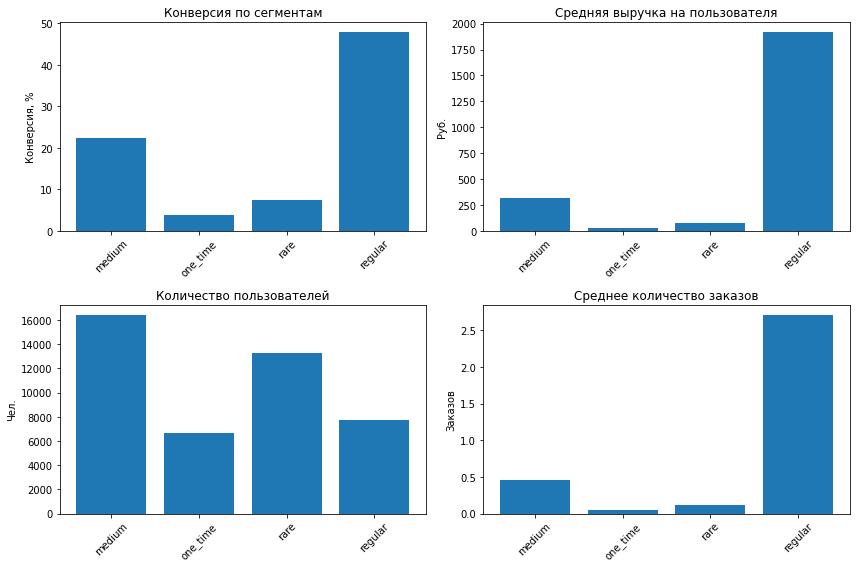

In [36]:
segment_analysis = pa_marketplace_users.merge(
    pa_marketplace_orders.groupby('user_id').agg(
        orders_count=('order_id', 'nunique'),
        total_spent=('total_price', 'sum'),
        marketplace_revenue=('marketplace_revenue', 'sum')
    ).reset_index(),
    on='user_id',
    how='left'
).fillna(0)

segment_stats = segment_analysis.groupby('buyer_segment').agg(
    users=('user_id', 'nunique'),
    buyers=('orders_count', lambda x: (x > 0).sum()),
    avg_orders=('orders_count', 'mean'),
    avg_revenue=('marketplace_revenue', 'mean')
).round(2)

segment_stats['conversion'] = segment_stats['buyers'] / segment_stats['users'] * 100
print("Анализ по сегментам покупателей:")
print(segment_stats)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].bar(segment_stats.index, segment_stats['conversion'])
axes[0, 0].set_title('Конверсия по сегментам')
axes[0, 0].set_ylabel('Конверсия, %')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(segment_stats.index, segment_stats['avg_revenue'])
axes[0, 1].set_title('Средняя выручка на пользователя')
axes[0, 1].set_ylabel('Руб.')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(segment_stats.index, segment_stats['users'])
axes[1, 0].set_title('Количество пользователей')
axes[1, 0].set_ylabel('Чел.')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(segment_stats.index, segment_stats['avg_orders'])
axes[1, 1].set_title('Среднее количество заказов')
axes[1, 1].set_ylabel('Заказов')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Разовые пользователи(one_time) имеют худшие показатели по всем срезам.Так же  rare и one_time это примерно половина пользователей,которые приносят бизнесу крайне малый доход при своём количесвте пользователей**

                                 orders    revenue  avg_order_value  \
category_name                                                         
Мебель для дома                     979  3580998.0          73156.0   
Бытовая техника                    1030  2248933.0          43669.0   
Украшения и часы                   1024  1718297.0          33560.0   
Спортивный инвентарь               1000  1165361.0          23307.0   
Товары для туризма                  970  1137318.0          23450.0   
Автотовары                         1043  1044822.0          20035.0   
Товары для кухни                   1237  1030402.0          16660.0   
Обувь мужская                      1253   942482.0          15044.0   
Сумки и аксессуары                 1180   873491.0          14805.0   
Обувь женская                      1211   860489.0          14211.0   
Инструменты и садовый инвентарь    1000   812373.0          16247.0   
Декор и освещение                  1053   703804.0          13368.0   
Аксесс

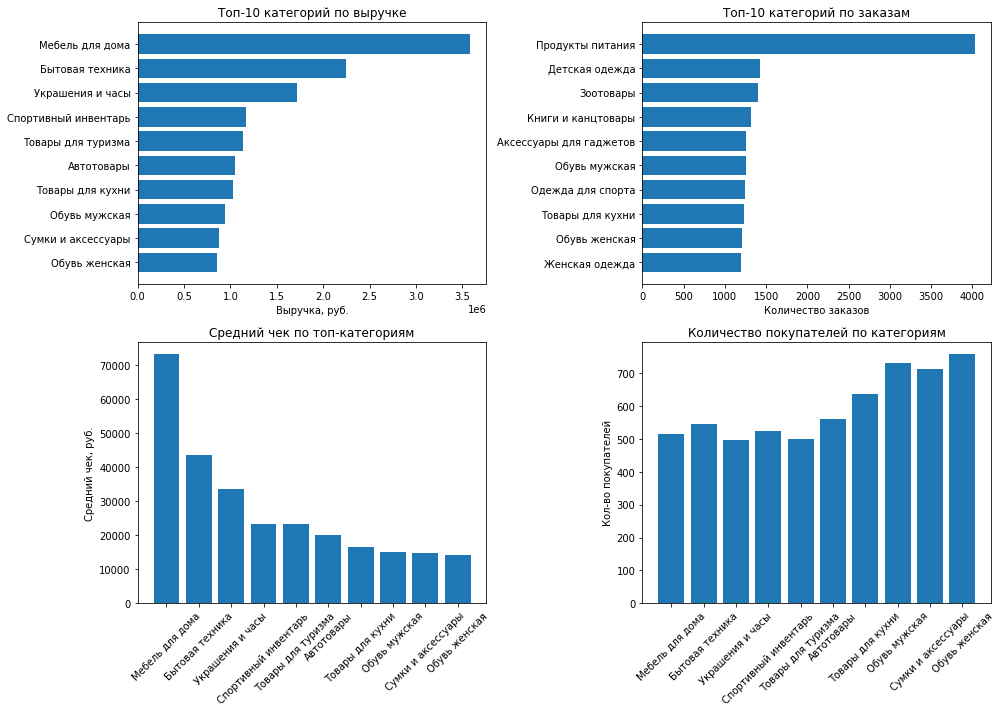

In [37]:
category_stats = pa_marketplace_orders.groupby('category_name').agg(
    orders=('order_id', 'nunique'),
    revenue=('marketplace_revenue', 'sum'),
    avg_order_value=('total_price', 'mean'),
    unique_buyers=('user_id', 'nunique')
).sort_values('revenue', ascending=False)

print(category_stats.round(0))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

top_revenue = category_stats.head(10)
axes[0, 0].barh(top_revenue.index, top_revenue['revenue'])
axes[0, 0].set_title('Топ-10 категорий по выручке')
axes[0, 0].set_xlabel('Выручка, руб.')
axes[0, 0].invert_yaxis()

top_orders = category_stats.sort_values('orders', ascending=False).head(10)
axes[0, 1].barh(top_orders.index, top_orders['orders'])
axes[0, 1].set_title('Топ-10 категорий по заказам')
axes[0, 1].set_xlabel('Количество заказов')
axes[0, 1].invert_yaxis()

axes[1, 0].bar(top_revenue.index, top_revenue['avg_order_value'])
axes[1, 0].set_title('Средний чек по топ-категориям')
axes[1, 0].set_ylabel('Средний чек, руб.')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(top_revenue.index, top_revenue['unique_buyers'])
axes[1, 1].set_title('Количество покупателей по категориям')
axes[1, 1].set_ylabel('Кол-во покупателей')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Визуализировали топ категорий и взглянули на распределения по категориям и товарам. Основное что можно заметить что пользователи покупают много дешевого, но мало дорогого.(Что в целом логично но даёт повод подумать над точками роста). Например Мебель, техника средний чек 43-73к руб., 500-600 покупателей, а продукты, зоотовары - чек 3-5к руб., 900-2700 покупателей.**

Анализ по регионам:
                    users  buyers  total_revenue  avg_revenue  avg_orders  \
region                                                                      
Другие регионы      14516  2816.0     6837361.32       471.02        0.68   
Москва              10959  2200.0     5410184.15       493.67        0.73   
Санкт-Петербург      6690  1317.0     3396292.57       507.67        0.70   
Московская область   3549   681.0     1658614.02       467.35        0.64   
Екатеринбург         2145   418.0     1143765.90       533.22        0.74   
Нижний Новгород      1748   354.0      841422.00       481.36        0.70   
Краснодар            1398   290.0      728837.63       521.34        0.68   
Новосибирск          1723   310.0      728729.05       422.94        0.62   
Ростов-на-Дону       1423   268.0      603704.79       424.25        0.64   

                    conversion  
region                          
Другие регионы           19.40  
Москва                   20.07  


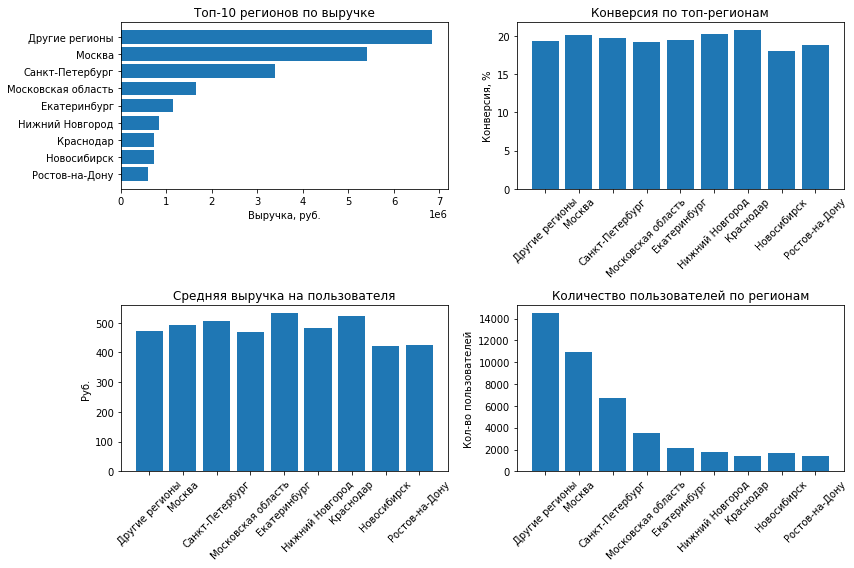

In [38]:
region_analysis = pa_marketplace_users.merge(
    pa_marketplace_orders.groupby('user_id').agg(
        total_revenue=('marketplace_revenue', 'sum'),
        orders_count=('order_id', 'nunique')
    ).reset_index(),
    on='user_id',
    how='left'
).fillna(0)

region_stats = region_analysis.groupby('region').agg(
    users=('user_id', 'nunique'),
    buyers=('total_revenue', lambda x: (x > 0).sum()),
    total_revenue=('total_revenue', 'sum'),
    avg_revenue=('total_revenue', 'mean'),
    avg_orders=('orders_count', 'mean')
).sort_values('total_revenue', ascending=False)

region_stats['conversion'] = region_stats['buyers'] / region_stats['users'] * 100
region_stats = region_stats.round(2)

print("Анализ по регионам:")
print(region_stats)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

top_regions = region_stats.head(10)
axes[0, 0].barh(top_regions.index, top_regions['total_revenue'])
axes[0, 0].set_title('Топ-10 регионов по выручке')
axes[0, 0].set_xlabel('Выручка, руб.')
axes[0, 0].invert_yaxis()

axes[0, 1].bar(top_regions.index, top_regions['conversion'])
axes[0, 1].set_title('Конверсия по топ-регионам')
axes[0, 1].set_ylabel('Конверсия, %')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(top_regions.index, top_regions['avg_revenue'])
axes[1, 0].set_title('Средняя выручка на пользователя')
axes[1, 0].set_ylabel('Руб.')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(top_regions.index, top_regions['users'])
axes[1, 1].set_title('Количество пользователей по регионам')
axes[1, 1].set_ylabel('Кол-во пользователей')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Анализ по регионам показывает стабильную конверсию ~19-20% по всем регионам без географических аномалий, лучшая монетизация в Екатеринбурге (533 руб./пользователя).**

     device       os  users  buyers  conversion
4    mobile  Android   1862   656.0       35.23
3   desktop    macOS   1824   617.0       33.83
7    mobile    macOS   1827   614.0       33.61
5    mobile  Windows   1843   619.0       33.59
9    tablet  Windows   1834   604.0       32.93
10   tablet      iOS   1825   601.0       32.93
8    tablet  Android   1834   603.0       32.88
2   desktop      iOS   1879   611.0       32.52
11   tablet    macOS   1767   569.0       32.20
0   desktop  Android   1827   586.0       32.07
1   desktop  Windows   1917   614.0       32.03
6    mobile      iOS   1899   604.0       31.81


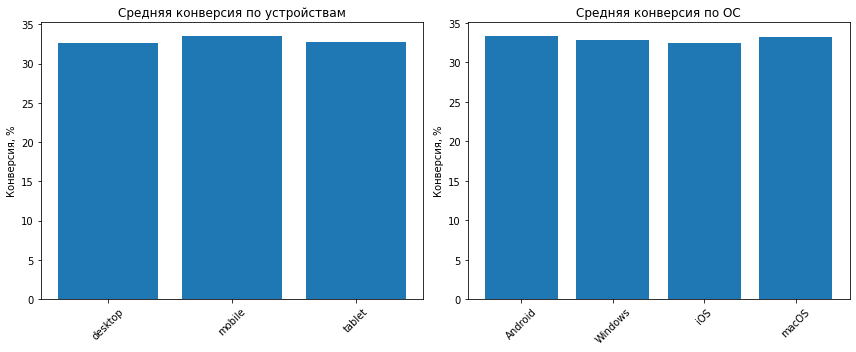

In [39]:
unique_device_users = pa_marketplace_events.drop_duplicates(['user_id', 'device', 'os'])

unique_device_users = unique_device_users.merge(
    pa_marketplace_orders[['user_id']].drop_duplicates().assign(is_buyer=1),
    on='user_id',
    how='left'
).fillna({'is_buyer': 0})

correct_conversion = unique_device_users.groupby(['device', 'os']).agg(
    users=('user_id', 'nunique'),
    buyers=('is_buyer', 'sum')
).reset_index()

correct_conversion['conversion'] = correct_conversion['buyers'] / correct_conversion['users'] * 100
correct_conversion = correct_conversion.sort_values('conversion', ascending=False)

print(correct_conversion.round(2))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

device_conv = correct_conversion.groupby('device').agg(
    avg_conversion=('conversion', 'mean')
).reset_index()

axes[0].bar(device_conv['device'], device_conv['avg_conversion'])
axes[0].set_title('Средняя конверсия по устройствам')
axes[0].set_ylabel('Конверсия, %')
axes[0].tick_params(axis='x', rotation=45)

os_conv = correct_conversion.groupby('os').agg(
    avg_conversion=('conversion', 'mean')
).reset_index()

axes[1].bar(os_conv['os'], os_conv['avg_conversion'])
axes[1].set_title('Средняя конверсия по ОС')
axes[1].set_ylabel('Конверсия, %')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Проблемных зон по устройствам и OC не прослеживается.Распределение равномерное,и все устройства с разными OC работают стабильно**

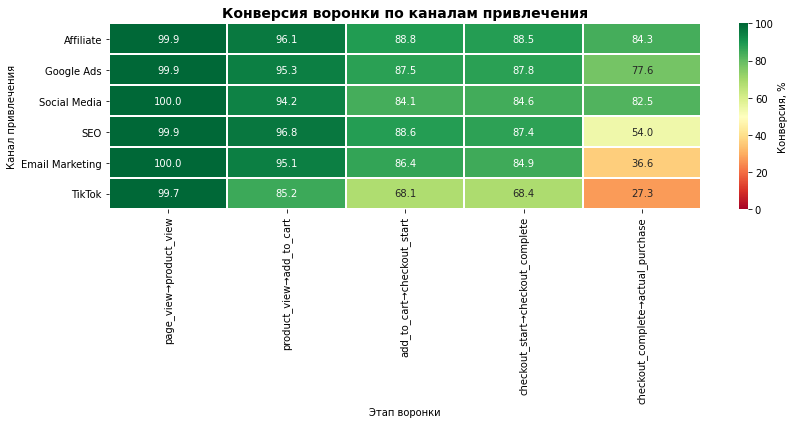

In [40]:
users_with_channels = pa_marketplace_users[['user_id', 'acq_channel']]

events_with_channels = pa_marketplace_events.merge(users_with_channels, on='user_id', how='left')
orders_with_channels = pa_marketplace_orders.merge(users_with_channels, on='user_id', how='left')

channels = [channel for channel in events_with_channels['acq_channel'].unique() if pd.notna(channel)]

heatmap_data = []
for channel in channels:
    
    channel_events = events_with_channels[events_with_channels['acq_channel'] == channel]
    channel_orders = orders_with_channels[orders_with_channels['acq_channel'] == channel]
    
    steps = ['page_view', 'product_view', 'add_to_cart', 'checkout_start', 'checkout_complete', 'actual_purchase']
    users_per_step = []
    
    users_per_step.append(channel_events[channel_events['event_type'] == 'page_view']['user_id'].nunique())
    users_per_step.append(channel_events[channel_events['event_type'] == 'product_view']['user_id'].nunique())
    users_per_step.append(channel_events[channel_events['event_type'] == 'add_to_cart']['user_id'].nunique())
    users_per_step.append(channel_events[channel_events['event_type'] == 'checkout_start']['user_id'].nunique())
    users_per_step.append(channel_events[channel_events['event_type'] == 'checkout_complete']['user_id'].nunique())
    users_per_step.append(channel_orders['user_id'].nunique())
    
    conv_rates = []
    for i in range(1, len(users_per_step)):
        if users_per_step[i-1] > 0:
            conv_rate = (users_per_step[i] / users_per_step[i-1] * 100)
            conv_rates.append(conv_rate)
        else:
            conv_rates.append(0)
    
    conv_dict = {'channel': channel}
    conv_dict.update(dict(zip([
        'page_view→product_view', 
        'product_view→add_to_cart', 
        'add_to_cart→checkout_start',
        'checkout_start→checkout_complete',
        'checkout_complete→actual_purchase'
    ], conv_rates)))
    heatmap_data.append(conv_dict)

heatmap_df = pd.DataFrame(heatmap_data)
heatmap_df = heatmap_df.set_index('channel')

heatmap_df['total_conversion'] = (heatmap_df.iloc[:, -1] / 100 * 
                                  heatmap_df.iloc[:, -2] / 100 *
                                  heatmap_df.iloc[:, -3] / 100 *
                                  heatmap_df.iloc[:, -4] / 100 *
                                  heatmap_df.iloc[:, -5] / 100 * 100)
heatmap_df = heatmap_df.sort_values('total_conversion', ascending=False)

heatmap_df_for_viz = heatmap_df.drop('total_conversion', axis=1)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_df_for_viz, 
            annot=True, 
            fmt='.1f', 
            cmap='RdYlGn',
            linewidths=1,
            linecolor='white',
            cbar_kws={'label': 'Конверсия, %'},
            vmin=0,
            vmax=100)
plt.title('Конверсия воронки по каналам привлечения', fontsize=14, fontweight='bold')
plt.xlabel('Этап воронки')
plt.ylabel('Канал привлечения')
plt.tight_layout()
plt.show()

**Канал Affiliate демонстрирует наилучшие показатели конверсии на всех этапах, особенно на финальном этапе оплаты (84.3%). Напротив, TikTok показывает критические потери: на этапе оформления заказа теряется 31.9% пользователей, а на этапе оплаты — 72.7%. Это подтверждает гипотезу о неэффективности TikTok как канала привлечения.**

**Ключевые проблемы сосредоточены на этапах "корзина - оформление" и "оформление - оплата" в каналах TikTok, Email Marketing и SEO. Рекомендуется перераспределить маркетинговый бюджет в пользу эффективных каналов (Affiliate, Social Media) и оптимизировать процесс оплаты для проблемных каналов.**

## Выводы по этапу 4

Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

**Проведя сегментацию данных, выявили ключевые проблемные зоны и точки роста продукта:**

**Проблемные зоны, требующие срочного внимания:**

Канал TikTok **расходует** 9.7 млн рублей (50% маркетингового бюджета), но показывает конверсию всего 3.7% — в 10 раз ниже лидеров. ROI канала составляет критические -90.6%, что делает его главной точкой убытков.

Сегменты **"one_time" и "rare" составляют 45% пользователей, но практически не приносят выручки.** Их конверсия составляет лишь 3.9% и 7.5%, а средняя выручка — 33 и 79 рублей соответственно.

**Воронка покупок теряет 54% пользователей на критических этапах:**

- 18% теряется при переходе из корзины в оформление
- 36% не завершают оплату после оформления заказа

**Пользователи покупают много дешевого, но мало дорогого:** категории продукты питания имеют 2,659 покупателей при чеке 2,962 рубля, а мебель для дома — только 514 покупателей при чеке 73,156 рублей.

**Места которые можно масштабировать:**
Каналы Affiliate и SEO демонстрируют ROI > 180% при стабильной конверсии 26-38% — эти каналы эффективны и могут масштабироваться.

Сегмент **"regular"** (17.6% пользователей) **приносит 67% выручки** с конверсией 47.8% — это основная лояльная аудитория.

Высокомаржинальные категории ("Мебель", "Бытовая техника") имеют средний чек 43-73 тысячи рублей — потенциал для увеличения среднего чека.

**Сформулированные гипотезы:**

- Гипотеза 1: Упрощение процесса оформления заказа повысит конверсию на 15% на этапе "корзина → оформление" (сейчас теряется 18% пользователей).

- Гипотеза 2: Улучшение страницы оплаты увеличит конверсию на 20% на этапе "оформление → оплата" (сейчас теряется 36% пользователей).

- Гипотеза 3: если сократить маркетинговый бюджет TikTok на 50% и перераспределить эти средства в каналы Affiliate и SEO, ТО общий ROI маркетинга вырастет на 30%, потому что TikTok имеет ROI -90.6% при конверсии 3.7%, тогда как Affiliate и SEO имеют ROI > 180% при конверсии 26-38%.

- Гипотеза 4: Программа лояльности для сегментов "one_time" и "rare" увеличит их конверсию на 25%.

**Рекомендации:**
Основной проблемой падения выручки и убытков продукта является отток активных пользователей.Стоит уделить гипотезам которые в могут помочь решить эту проблему приорететное внимание. Не допускать потерю пользователей на этапах воронки в больших количествах и повысить интерес пользователей через прогррамы лояльности и специализированные предложения.

## 5. Подготовка эксперимента и подведение его результатов

Получите вводную информацию для выполнения этого этапа у ревьюера после успешного завершения предыдущих шагов.

# Новые вводные (после этапа 4)
Команда продукта рассмотрела твои гипотезы и на основании этого решила влиять на конверсию при помощи финансовых стимуляций. Так как ситуация со снижением выручки срочная и безотлагательная, пока ты продолжал изучать данные, они подключили другого аналитика для подготовки дизайн документа, но само проведение эксперимента на тебе.


При формировании выводов допиши рекомендации по итогам теста и, если необходимо, опиши проблемы, присутствующие в эксперименте.


## Новые данные:
```python
pa_marketplace_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events_AB.csv')
pa_marketplace_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders_AB.csv')
pa_marketplace_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users_AB.csv')
```
## Результаты сплита лежат в таблице:
```python
pa_marketplace_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_AB_split_users.csv')
```
* user_id – id клиента
* group – группа, в которую попал клиент


# Дизайн эксперимента: Бонус на первую покупку для пользователей TikTok
## 1. Контекст и цель эксперимента
- **Бизнес-контекст:** Команда продукта запускает эксперимент, направленный на повышение конверсии среди пользователей, привлечённых через канал TikTok. Для стимулирования первой покупки пользователям будет предоставлен бонус на первую покупку.
- **Цель:** Проверить, влияет ли предоставление бонуса на первую покупку на конверсию и выручку среди пользователей TikTok.
- **Гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку
---
## 2. Формат эксперимента
- **Тип эксперимента:** Сплит-роллинг (rolling split)
- **Канал:** Только пользователи, пришедшие с TikTok
- **Группы:**
    - **Контрольная (A):** пользователи TikTok без бонуса
    - **Тестовая (B):** пользователи TikTok с бонусом на первую покупку
- **Распределение:** Равномерное распределение новых пользователей TikTok между группами по дате регистрации
- **Период проведения:** 3 недели (фиксировано)
---
## 3. Ключевые метрики
### Основная метрика
- **Конверсия в первую покупку** — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку
- *Цель:* увеличить конверсию с помощью бонуса
- *Критерий успеха:* статистически значимый рост конверсии в тестовой группе
### Вспомогательные метрики
- **ARPU** (средняя выручка на пользователя TikTok)
- **ARPPU** (средняя выручка на покупателя TikTok)
- **AOV** (средний чек TikTok)
### Барьерная метрика
- **Общая выручка от пользователей TikTok**
---
## 4. Размеры групп и запуск
- **Целевая аудитория:** только пользователи TikTok
- **Размеры групп:** определяются по фактическому трафику TikTok за период эксперимента
- **Комментарий:** запуск без предварительного расчёта мощности и MDE из-за срочности задачи


## Познакомимся и изучим новые данные и результаты сплита

In [41]:
pa_marketplace_events_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_events_AB.csv', parse_dates = ['event_date', 'event_week', 'event_month'])
pa_marketplace_orders_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_orders_AB.csv', parse_dates = ['order_date', 'order_week', 'order_month'])
pa_marketplace_users_AB = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_users_AB.csv', parse_dates = ['registration_date', 'cohort_week', 'cohort_month'])
#Результаты сплита 
pa_marketplace_AB_split_users = pd.read_csv('https://code.s3.yandex.net/datasets/pa_marketplace_AB_split_users.csv')

display(pa_marketplace_events_AB.head())
display(pa_marketplace_orders_AB.head())
display(pa_marketplace_users_AB.head())
#Результаты сплита 
display(pa_marketplace_AB_split_users.head())

display(pa_marketplace_events_AB.info())
display(pa_marketplace_orders_AB.info())
display(pa_marketplace_users_AB.info())
#Результаты сплита 
display(pa_marketplace_AB_split_users.info())

#Проверяем, что все данные за один период
print(f"Пользователи: {pa_marketplace_users_AB['registration_date'].min()} - {pa_marketplace_users_AB['registration_date'].max()}")
print(f"События: {pa_marketplace_events_AB['event_date'].min()} - {pa_marketplace_events_AB['event_date'].max()}")
print(f"Заказы: {pa_marketplace_orders_AB['order_date'].min()} - {pa_marketplace_orders_AB['order_date'].max()}")


#Проверяем, что распределение примерно 50/50
group_dist = pa_marketplace_AB_split_users['group'].value_counts()
print(f'\n{group_dist}')
print(f"\nСоотношение: {round(group_dist['treatment']/group_dist['control'], 2)}%")

#Проверяем, все ли пользователи TikTok попали в сплит
users_with_split = pa_marketplace_users_AB.merge(pa_marketplace_AB_split_users, on='user_id', how='left')
tiktok_users  = users_with_split[users_with_split['acq_channel'] == 'TikTok']
print(f"\nВсего пользователей TikTok: {len(tiktok_users)}")
print(f"Из них попали в сплит: {tiktok_users['group'].notna().sum()}")
print(f"Процент покрытия: {round(tiktok_users['group'].notna().mean()*100,2)}%")

#Проверяем, не попали ли пользователи других каналов в сплит
other_channels = users_with_split[users_with_split['acq_channel'] != 'TikTok']
print(f"\nПользователей не TikTok в сплите: {other_channels['group'].notna().sum()}")

#Проверяем, есть ли user_id, которые встречаются в обеих группах
user_group_counts = pa_marketplace_AB_split_users.groupby('user_id')['group'].nunique()
duplicate_users = user_group_counts[user_group_counts > 1]

print(f"\nПользователей в обеих группах: {len(duplicate_users)}")

#Уникальные группы
print(pa_marketplace_AB_split_users['group'].unique())

,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month
0,3132,100,2024-01-01 15:23:56,page_view,iOS,mobile,NaN,2024-01-01,2024-01-01
1,3133,100,2024-01-01 15:24:01,product_view,iOS,mobile,Шорты для тренировок,2024-01-01,2024-01-01
2,3134,100,2024-01-01 15:24:10,product_click,iOS,mobile,Куртка детская,2024-01-01,2024-01-01
3,3135,100,2024-01-01 15:25:10,add_to_cart,iOS,mobile,Балетки классические,2024-01-01,2024-01-01
4,3136,100,2024-01-01 15:25:46,checkout_start,iOS,mobile,NaN,2024-01-01,2024-01-01


,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
0,1,3,2024-01-19 01:52:52,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
1,2,3,2024-01-19 01:52:52,Молоток слесарный,1,11340.38,11340.38,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
2,3,3,2024-01-19 01:52:52,Секатор садовый,2,10892.09,21784.18,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
3,4,3,2024-01-25 13:59:38,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-22,2024-01-01
4,5,3,2024-01-25 13:59:38,Чай черный,1,2099.59,2099.59,Продукты питания,2024-01-22,2024-01-01


,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month
0,18,2024-01-01 05:26:00,49,M,Екатеринбург,TikTok,one_time,2024-01-01,2024-01-01
1,22,2024-01-01 17:13:00,50,M,Санкт-Петербург,TikTok,one_time,2024-01-01,2024-01-01
2,26,2024-01-01 21:15:00,60,F,Москва,TikTok,rare,2024-01-01,2024-01-01
3,33,2024-01-01 14:43:00,31,M,Екатеринбург,TikTok,rare,2024-01-01,2024-01-01
4,39,2024-01-01 01:13:00,44,M,Санкт-Петербург,TikTok,rare,2024-01-01,2024-01-01


,user_id,group
0,44965,control
1,44967,control
2,44968,control
3,44969,treatment
4,44970,control


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831231 entries, 0 to 831230
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      831231 non-null  int64         
 1   user_id       831231 non-null  int64         
 2   event_date    831231 non-null  datetime64[ns]
 3   event_type    831231 non-null  object        
 4   os            831231 non-null  object        
 5   device        831231 non-null  object        
 6   product_name  409054 non-null  object        
 7   event_week    831231 non-null  datetime64[ns]
 8   event_month   831231 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 57.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33280 entries, 0 to 33279
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       33280 non-null  int64         
 1   user_id        33280 non-null  int64         
 2   order_date     33280 non-null  datetime64[ns]
 3   product_name   33280 non-null  object        
 4   quantity       33280 non-null  int64         
 5   unit_price     33280 non-null  float64       
 6   total_price    33280 non-null  float64       
 7   category_name  33280 non-null  object        
 8   order_week     33280 non-null  datetime64[ns]
 9   order_month    33280 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 2.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22196 entries, 0 to 22195
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            22196 non-null  int64         
 1   registration_date  22196 non-null  datetime64[ns]
 2   age                22196 non-null  int64         
 3   gender             22196 non-null  object        
 4   region             22196 non-null  object        
 5   acq_channel        22196 non-null  object        
 6   buyer_segment      22196 non-null  object        
 7   cohort_week        22196 non-null  datetime64[ns]
 8   cohort_month       22196 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 1.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  2968 non-null   int64 
 1   group    2968 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.5+ KB


None

Пользователи: 2024-01-01 01:13:00 - 2025-01-26 23:41:00
События: 2024-01-01 15:23:56 - 2025-01-26 23:59:34
Заказы: 2024-01-01 08:03:45 - 2025-01-26 23:07:50

control      1503
treatment    1465
Name: group, dtype: int64

Соотношение: 0.97%

Всего пользователей TikTok: 22196
Из них попали в сплит: 2968
Процент покрытия: 13.37%

Пользователей не TikTok в сплите: 0

Пользователей в обеих группах: 0
['control' 'treatment']


**Провели предворительную проверку данных.Промежуточные выводы:**

- Спарсили даты на этапе загрузки и познакомились с данными
- Распределение хорошое(50.6%/49.4%)
- Все пользователи только из TikTok 
- Нет пользователей в обеих группах 
- Нет пользователей других каналов в сплите 

**Данныее в датафрефмах за весь год,нужно отфильтровать их для дальнейшего проведения теста по сплитованному датафрейму**


In [42]:
split_user_ids = pa_marketplace_AB_split_users['user_id'].unique()

events_for_analysis = pa_marketplace_events_AB[
    pa_marketplace_events_AB['user_id'].isin(split_user_ids)
]

orders_for_analysis = pa_marketplace_orders_AB[
    pa_marketplace_orders_AB['user_id'].isin(split_user_ids)
]

events_for_analysis = events_for_analysis.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='left'
)

orders_for_analysis = orders_for_analysis.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='left'
)

In [43]:
print("1. Союытия пользователей из сплита:")
print(f"   Начало: {events_for_analysis['event_date'].min()}")
print(f"   Конец: {events_for_analysis['event_date'].max()}")
print(f"   Длительность: {(events_for_analysis['event_date'].max() - events_for_analysis['event_date'].min()).days} дней")

print("\n2. Заказы пользователей из сплита:")
print(f"   Начало: {orders_for_analysis['order_date'].min()}")
print(f"   Конец: {orders_for_analysis['order_date'].max()}")
print(f"   Длительность: {(orders_for_analysis['order_date'].max() - orders_for_analysis['order_date'].min()).days} дней")

print("\n3.Даты регестрации пользователей в сплите:")

users_in_split = pa_marketplace_users_AB[
    pa_marketplace_users_AB['user_id'].isin(split_user_ids)
]
print(f"   Начало: {users_in_split['registration_date'].min()}")
print(f"   Конец: {users_in_split['registration_date'].max()}")
print(f"   Длительность: {(users_in_split['registration_date'].max() - users_in_split['registration_date'].min()).days} дней")

1. Союытия пользователей из сплита:
   Начало: 2025-01-02 03:25:32
   Конец: 2025-01-26 23:46:15
   Длительность: 24 дней

2. Заказы пользователей из сплита:
   Начало: 2025-01-01 11:57:43
   Конец: 2025-01-26 20:39:35
   Длительность: 25 дней

3.Даты регестрации пользователей в сплите:
   Начало: 2025-01-01 00:05:00
   Конец: 2025-01-26 23:41:00
   Длительность: 25 дней


**Провели фильтрацию и проверели даты на соответсвие**

- Период тестирования: 1-26 января 2025 года (25 дней)

**Тест длился больше установленного срока 25 дней вместо запланированных 21 дня**

**События начались со 2 января (возможно, пользователи не сразу активны после регистрации)**

**Эксперемент выпадает на праздники. В праздники люди меняют своё привычное поведение. Например, едут в отпуск или на дачу. Из-за этого эксперимент может показать завышенные или заниженные результаты. Запускать эксперимент в праздники можно, но важно верно интерпретировать результаты. В обычные дни они могут быть совсем другими.** 

**Чтобы упростить процесс дизайна и снизить вероятность проблем, лучше следовать таким правилам:** 
- Не запускать эксперименты в праздники и в период нестандартных событий.
- Всегда учитывать сезонность поведения пользователей. Например, если в продукте ярко выражена недельная сезонность, то длительность эксперимента должна быть кратна одной неделе.
- Не запускать эксперименты в четверг и пятницу: в выходные будет сложно отреагировать на возможные проблемы пользователей.

## Проверим дизайн эксперимента: Бонус на первую покупку для пользователей TikTok

**Выводы по дизайну эксперемента**

**1. Контекст и цель эксперимента**

Ознакомился с бизнес контекстом и целью.Гипотеза должна быть конкретной и измеримой.Наша гипотеза в целом составлена хорошо,конечно можно было бы уточнить насколько должна увеличиться конверсия. На 1%? На 50%?.Если мы получим статистически значимое изменение,не факт что практически будет значим этот рост.

**2. Формат эксперимента**

В целом формат эксперемента понятен. Подход у нас с жёстко фиксированными параметрами(3 недели)

Это удобно для планирования, но нам нужно проверить параметры. Некоторые из них могут быть нерелевантны желаемому результату — например, может не хватить трафика для заданного MDE(Которого у нас нету из за срочности). 

**3.Ключевая метрика считаю подобрана правильно(как и вспомогательная так и барьерная).Единственное я бы предложил поменять кретерий успеха.**

**Считаю правильно он должен звучать так: Критерий успеха: статистически значимый рост конверсии в тестовой группе при отсутствие негативного влияния на барьерную метрику**

**4.Размеры групп и запуск**

**Крайне неправильно запускать тест при таких условиях:
Комментарий: запуск без предварительного расчёта мощности и MDE из-за срочности задачи**

**Да мы можем увидеть статистическую значимость после проведения эксперимента, но будет ли она достаточной для бизнеса?Мб бизнесу нужно больше что бы окупиться и какой результат считать успехом? +1% уже хорошо оли нужно +15%?**

**Отсутствие расчёта мощьности приводи к то что неизвестно, достаточно ли 2,968 пользователей,а так же к риску ошибки 2-го рода: пропустить реальный эффект**






# Проведение эксперемента

## Расчитываем основную метрику и её p-value

*Сформируем две гипотезы:*
- H0(Конверсия в тестовой группе равна конверсии в контрольной группе
- H1(Конверсия в тестовой группе больше конверсии в контрольной группе)

In [44]:
users_analysis = pa_marketplace_AB_split_users.copy()
users_with_purchases = orders_for_analysis['user_id'].unique()
users_analysis['made_purchase'] = users_analysis['user_id'].isin(users_with_purchases).astype(int)

conversion_stats = users_analysis.groupby('group').agg(
    users=('user_id', 'count'),
    buyers=('made_purchase', 'sum')
).reset_index()

conversion_stats['conversion_rate'] = conversion_stats['buyers'] / conversion_stats['users'] * 100

print("\nКонверсия по группам:")
for idx, row in conversion_stats.iterrows():
    print(f"Группа {row['group']}: {row['buyers']:,}/{row['users']:,} = {row['conversion_rate']:.2f}%")


Конверсия по группам:
Группа control: 16/1,503 = 1.06%
Группа treatment: 110/1,465 = 7.51%


In [45]:
groups_data = []
for group in ['control', 'treatment']:
    group_stats = conversion_stats[conversion_stats['group'] == group]
    groups_data.append({
        'group': group,
        'users': group_stats['users'].values[0],
        'buyers': group_stats['buyers'].values[0],
        'conversion': group_stats['conversion_rate'].values[0]
    })

group1 = 'control'
group2 = 'treatment'

data_group1 = [d for d in groups_data if d['group'] == group1][0]
data_group2 = [d for d in groups_data if d['group'] == group2][0]

count = [data_group2['buyers'], data_group1['buyers']]
nobs = [data_group2['users'], data_group1['users']]

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

mean_a = data_group1['conversion']
mean_b = data_group2['conversion']
absolute_lift = mean_b - mean_a
relative_lift = (mean_b / mean_a - 1) * 100 if mean_a > 0 else 0

results = []
results.append({
    'Группа A': group1,
    'Группа B': group2,
    'Z-статистика': f"{z_stat}",
    'P-value': f"{p_value}",
    'Абсолютный lift': f"{absolute_lift:.2f}",
    'Относительный lift': f"{relative_lift:.2f}"
})

results_df = pd.DataFrame(results)
print(results_df)

  Группа A   Группа B       Z-статистика                P-value  \
0  control  treatment  8.705387851371228  1.582452894902882e-18   

  Абсолютный lift Относительный lift  
0            6.44             605.33  


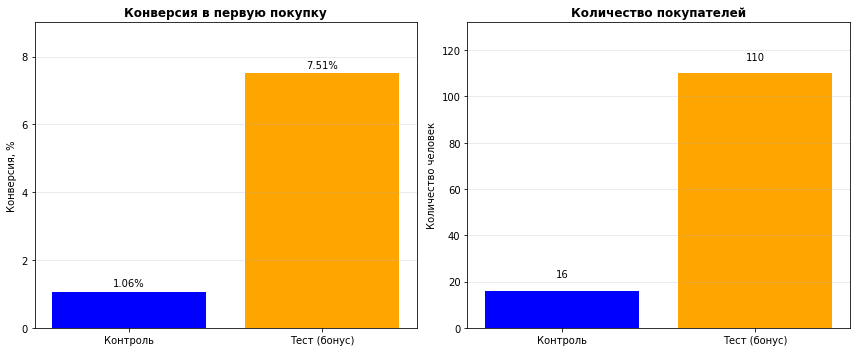

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

groups = ['Контроль', 'Тест (бонус)']
conversion_values = [mean_a, mean_b]

bars1 = axes[0].bar(groups, conversion_values, color=['blue', 'orange'])
axes[0].set_title('Конверсия в первую покупку', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Конверсия, %')
axes[0].set_ylim(0, max(conversion_values) * 1.2)
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars1, conversion_values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.2f}%', ha='center', va='bottom')

buyers_count = [data_group1['buyers'], data_group2['buyers']]

bars2 = axes[1].bar(groups, buyers_count, color=['blue', 'orange'])
axes[1].set_title('Количество покупателей', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Количество человек')
axes[1].set_ylim(0, max(buyers_count) * 1.2)
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars2, buyers_count):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{value:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

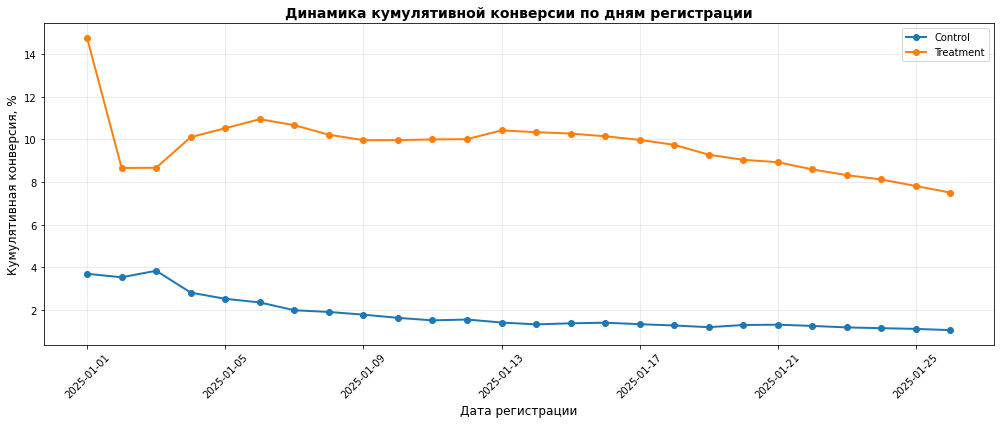

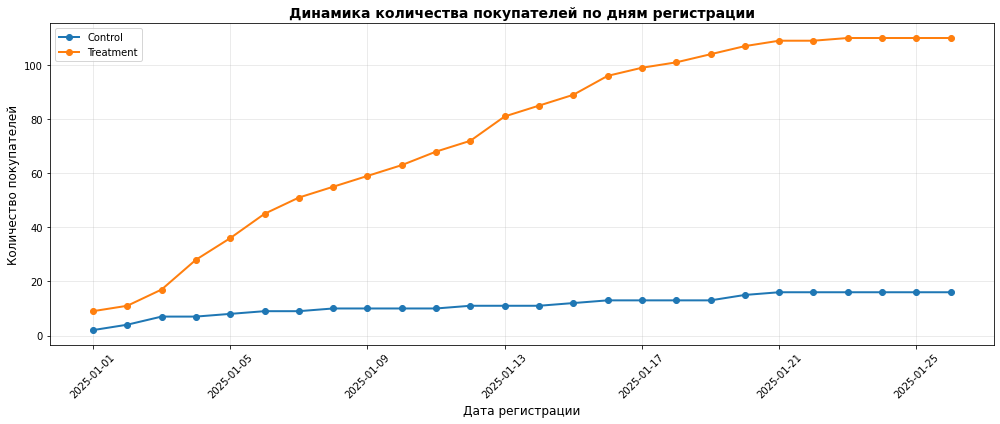

In [47]:
users_analysis_with_registration = users_analysis.merge(
    pa_marketplace_users_AB[['user_id', 'registration_date']],
    on='user_id',
    how='left'
)

users_analysis_with_registration['reg_date'] = users_analysis_with_registration['registration_date'].dt.date

daily_conversion_data = []

all_dates = sorted(users_analysis_with_registration['reg_date'].unique())

for current_date in all_dates:
    for group in ['control', 'treatment']:
        group_users_to_date = users_analysis_with_registration[
            (users_analysis_with_registration['group'] == group) &
            (users_analysis_with_registration['reg_date'] <= current_date)
        ]
        
        total_users = len(group_users_to_date)
        
        buyers_to_date = group_users_to_date['made_purchase'].sum()
        
        conversion_rate = (buyers_to_date / total_users * 100) if total_users > 0 else 0
        
        daily_conversion_data.append({
            'date': current_date,
            'group': group,
            'total_users': total_users,
            'buyers': buyers_to_date,
            'conversion_rate': conversion_rate
        })

daily_conversion_df = pd.DataFrame(daily_conversion_data)

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_conversion_df[daily_conversion_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['conversion_rate'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика кумулятивной конверсии по дням регистрации', fontsize=14, fontweight='bold')
plt.xlabel('Дата регистрации', fontsize=12)
plt.ylabel('Кумулятивная конверсия, %', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_conversion_df[daily_conversion_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['buyers'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика количества покупателей по дням регистрации', fontsize=14, fontweight='bold')
plt.xlabel('Дата регистрации', fontsize=12)
plt.ylabel('Количество покупателей', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Так-как метрика унас конверсия,использовали Z-тест и обноружили сисльную статистическую значимоть p_value(1.582452894902882e-18<0.05). Поэтому принимаем альтернативную гипотезу. ПБонус на первую покупку увеличил конверсию пользователей TikTok с 1.06% до 7.51% (абсолютный рост +6.45 п.п., относительный рост в 7 раз).**

## Расчитываем вспомогательные метрики

In [48]:
start_date = pd.Timestamp('2025-01-01 00:00:00')
end_date = pd.Timestamp('2025-01-26 23:59:59')

active_users_period = pa_marketplace_events_AB[
    (pa_marketplace_events_AB['event_date'] >= start_date) &
    (pa_marketplace_events_AB['event_date'] <= end_date)
][['user_id']].drop_duplicates()

active_users_with_groups = active_users_period.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='inner'
)

success_purchases = orders_for_analysis[
    (orders_for_analysis['order_date'] >= start_date) &
    (orders_for_analysis['order_date'] <= end_date)
].copy()

success_purchases['marketplace_revenue'] = success_purchases['total_price'] * 0.05

success_purchases_with_groups = success_purchases.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='inner'
)

users_count = active_users_with_groups.groupby('group')['user_id'].nunique()

group_col = [col for col in success_purchases_with_groups.columns if 'group' in col][0]
revenue_sum = success_purchases_with_groups.groupby(group_col)['marketplace_revenue'].sum()

results_df = pd.DataFrame({
    'users': users_count,
    'revenue': revenue_sum,
    'ARPU': revenue_sum / users_count
}).reset_index()

if 'index' in results_df.columns:
    results_df = results_df.rename(columns={'index': 'group'})

print(results_df.to_string(index=False))

    group  users     revenue       ARPU
  control    261  18918.6450  72.485230
treatment    238 192279.8515 807.898536


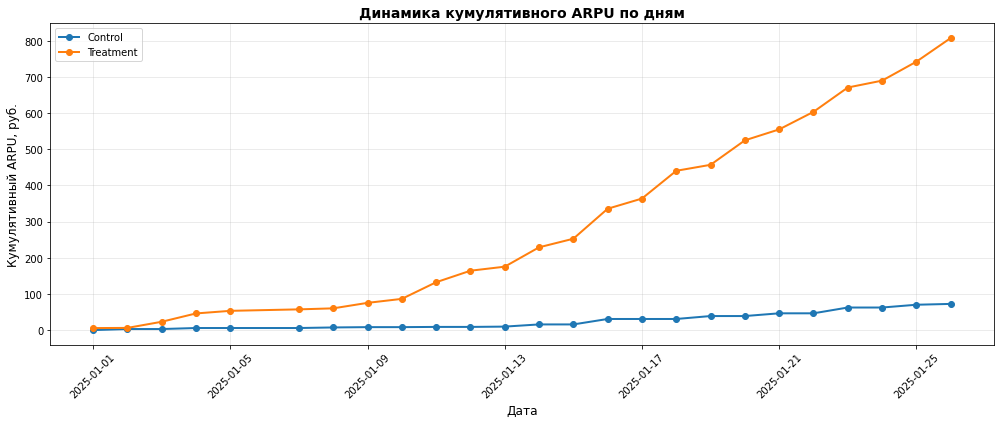

In [49]:
success_purchases_with_groups['order_date_only'] = success_purchases_with_groups['order_date'].dt.date

daily_arpu_data = []
all_purchase_dates = sorted(success_purchases_with_groups['order_date_only'].unique())

for current_date in all_purchase_dates:
    for group in ['control', 'treatment']:
        revenue_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['marketplace_revenue'].sum()
        
        active_to_date = active_users_with_groups[
            (active_users_with_groups['group'] == group)
        ]['user_id'].nunique()
        
        arpu = revenue_to_date / active_to_date if active_to_date > 0 else 0
        
        daily_arpu_data.append({
            'date': current_date,
            'group': group,
            'revenue': revenue_to_date,
            'active_users': active_to_date,
            'ARPU': arpu
        })

daily_arpu_df = pd.DataFrame(daily_arpu_data)

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_arpu_df[daily_arpu_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['ARPU'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика кумулятивного ARPU по дням', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивный ARPU, руб.', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**В тестовой группе с 3 дня нэксперемента наблюдается значительный рост тренда**

    group  paying_users     revenue       ARPPU
  control            16  18918.6450 1182.415313
treatment           110 192279.8515 1747.998650


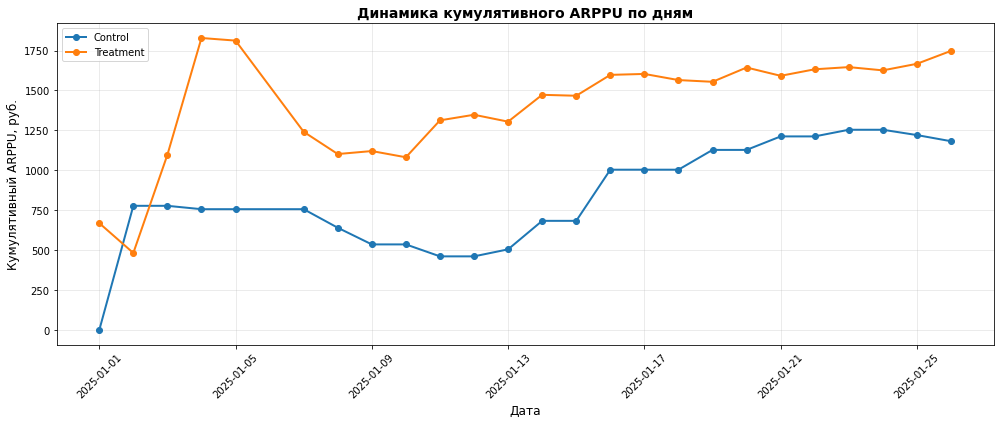

In [50]:
start_date = pd.Timestamp('2025-01-01 00:00:00')
end_date = pd.Timestamp('2025-01-26 23:59:59')

success_purchases = orders_for_analysis[
    (orders_for_analysis['order_date'] >= start_date) &
    (orders_for_analysis['order_date'] <= end_date)
].copy()

success_purchases['marketplace_revenue'] = success_purchases['total_price'] * 0.05

success_purchases_with_groups = success_purchases.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='inner'
)

success_purchases_with_groups['order_date_only'] = success_purchases_with_groups['order_date'].dt.date

group_col = [col for col in success_purchases_with_groups.columns if 'group' in col][0]

all_purchase_dates = sorted(success_purchases_with_groups['order_date_only'].unique())

paying_users_count = success_purchases_with_groups.groupby(group_col)['user_id'].nunique()
revenue_sum = success_purchases_with_groups.groupby(group_col)['marketplace_revenue'].sum()

results_df_arppu = pd.DataFrame({
    'paying_users': paying_users_count,
    'revenue': revenue_sum,
    'ARPPU': revenue_sum / paying_users_count
}).reset_index()

results_df_arppu = results_df_arppu.rename(columns={group_col: 'group'})

print(results_df_arppu.to_string(index=False))


daily_arppu_data = []

for current_date in all_purchase_dates:
    for group in ['control', 'treatment']:
        revenue_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['marketplace_revenue'].sum()
        
        paying_users_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['user_id'].nunique()
        
        arppu = revenue_to_date / paying_users_to_date if paying_users_to_date > 0 else 0
        
        daily_arppu_data.append({
            'date': current_date,
            'group': group,
            'revenue': revenue_to_date,
            'paying_users': paying_users_to_date,
            'ARPPU': arppu
        })

daily_arppu_df = pd.DataFrame(daily_arppu_data)

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_arppu_df[daily_arppu_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['ARPPU'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика кумулятивного ARPPU по дням', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивный ARPPU, руб.', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**ARPPU так же показывает более высокий тренд по сравнению с контрольной группой**

    group  orders     revenue        AOV
  control      24  18918.6450 788.276875
treatment     231 192279.8515 832.380310


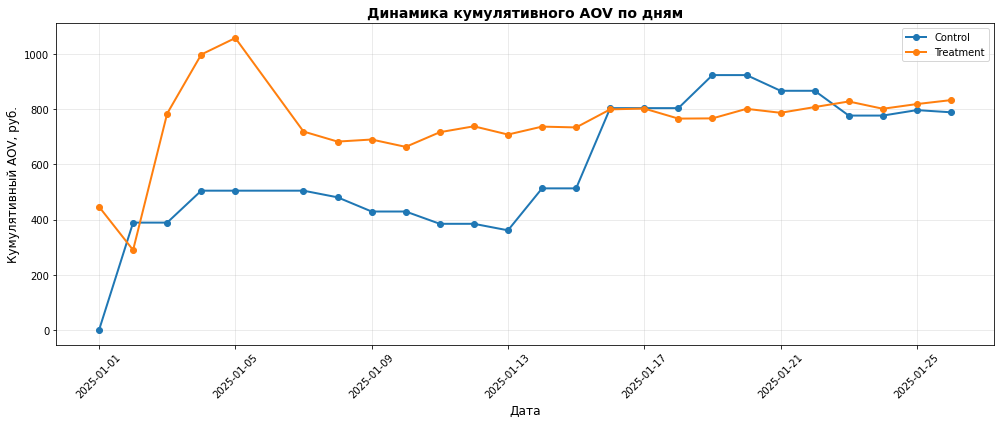

In [51]:
start_date = pd.Timestamp('2025-01-01 00:00:00')
end_date = pd.Timestamp('2025-01-26 23:59:59')

success_purchases = orders_for_analysis[
    (orders_for_analysis['order_date'] >= start_date) &
    (orders_for_analysis['order_date'] <= end_date)
].copy()

success_purchases['marketplace_revenue'] = success_purchases['total_price'] * 0.05

success_purchases_with_groups = success_purchases.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='inner'
)

success_purchases_with_groups['order_date_only'] = success_purchases_with_groups['order_date'].dt.date

group_col = [col for col in success_purchases_with_groups.columns if 'group' in col][0]

all_purchase_dates = sorted(success_purchases_with_groups['order_date_only'].unique())

orders_count = success_purchases_with_groups.groupby(group_col)['order_id'].nunique()
revenue_sum = success_purchases_with_groups.groupby(group_col)['marketplace_revenue'].sum()

results_df_aov = pd.DataFrame({
    'orders': orders_count,
    'revenue': revenue_sum,
    'AOV': revenue_sum / orders_count
}).reset_index()

results_df_aov = results_df_aov.rename(columns={group_col: 'group'})

print(results_df_aov.to_string(index=False))


daily_aov_data = []

for current_date in all_purchase_dates:
    for group in ['control', 'treatment']:
        revenue_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['marketplace_revenue'].sum()
        
        orders_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['order_id'].nunique()
        
        aov = revenue_to_date / orders_to_date if orders_to_date > 0 else 0
        
        daily_aov_data.append({
            'date': current_date,
            'group': group,
            'revenue': revenue_to_date,
            'orders': orders_to_date,
            'AOV': aov
        })

daily_aov_df = pd.DataFrame(daily_aov_data)

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_aov_df[daily_aov_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['AOV'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика кумулятивного AOV по дням', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивный AOV, руб.', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Средний чек в целом был выше,хоть и на 17 день эксперемента сравнялся,после до 22 стал ниже чем у контрольной группы. Дальше тренд снова стал выше. В среднем AOV в тестовой группе оказался выше чем в контрольной.**

## Расчитаем барьерную метрику

    group  total_revenue
  control     18918.6450
treatment    192279.8515


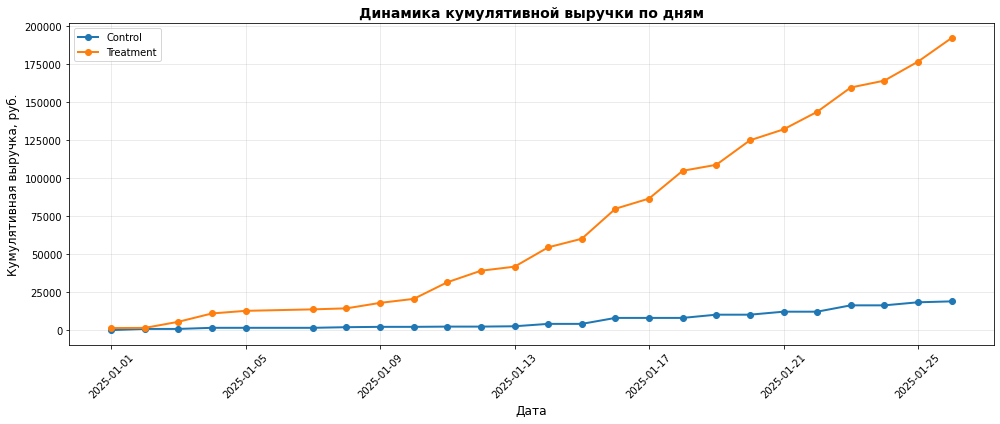

In [52]:
start_date = pd.Timestamp('2025-01-01 00:00:00')
end_date = pd.Timestamp('2025-01-26 23:59:59')

success_purchases = orders_for_analysis[
    (orders_for_analysis['order_date'] >= start_date) &
    (orders_for_analysis['order_date'] <= end_date)
].copy()

success_purchases['marketplace_revenue'] = success_purchases['total_price'] * 0.05

success_purchases_with_groups = success_purchases.merge(
    pa_marketplace_AB_split_users[['user_id', 'group']],
    on='user_id',
    how='inner'
)

success_purchases_with_groups['order_date_only'] = success_purchases_with_groups['order_date'].dt.date

group_col = [col for col in success_purchases_with_groups.columns if 'group' in col][0]

all_purchase_dates = sorted(success_purchases_with_groups['order_date_only'].unique())

revenue_sum = success_purchases_with_groups.groupby(group_col)['marketplace_revenue'].sum()

results_df_revenue = pd.DataFrame({
    'total_revenue': revenue_sum
}).reset_index()

results_df_revenue = results_df_revenue.rename(columns={group_col: 'group'})

print(results_df_revenue.to_string(index=False))

daily_revenue_cumulative_data = []

for current_date in all_purchase_dates:
    for group in ['control', 'treatment']:
        revenue_to_date = success_purchases_with_groups[
            (success_purchases_with_groups[group_col] == group) &
            (success_purchases_with_groups['order_date_only'] <= current_date)
        ]['marketplace_revenue'].sum()
        
        daily_revenue_cumulative_data.append({
            'date': current_date,
            'group': group,
            'cumulative_revenue': revenue_to_date
        })

daily_revenue_cumulative_df = pd.DataFrame(daily_revenue_cumulative_data)

plt.figure(figsize=(14, 6))

for group in ['control', 'treatment']:
    group_data = daily_revenue_cumulative_df[daily_revenue_cumulative_df['group'] == group].sort_values('date')
    plt.plot(group_data['date'], group_data['cumulative_revenue'], 
             label=f'{group.capitalize()}', marker='o', linewidth=2)

plt.title('Динамика кумулятивной выручки по дням', fontsize=14, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная выручка, руб.', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Барьерная метрика не упала,а наоброт показывает положительную тенденцию по сравнению с контрольной группой**

## Ищем инсайты

**Если применить проактивный подход к аналитике, то из данных эксперимента зачастую можно извлечь дополнительные инсайты, которые могут пригодиться в разработке и тестировании новых гипотез.**

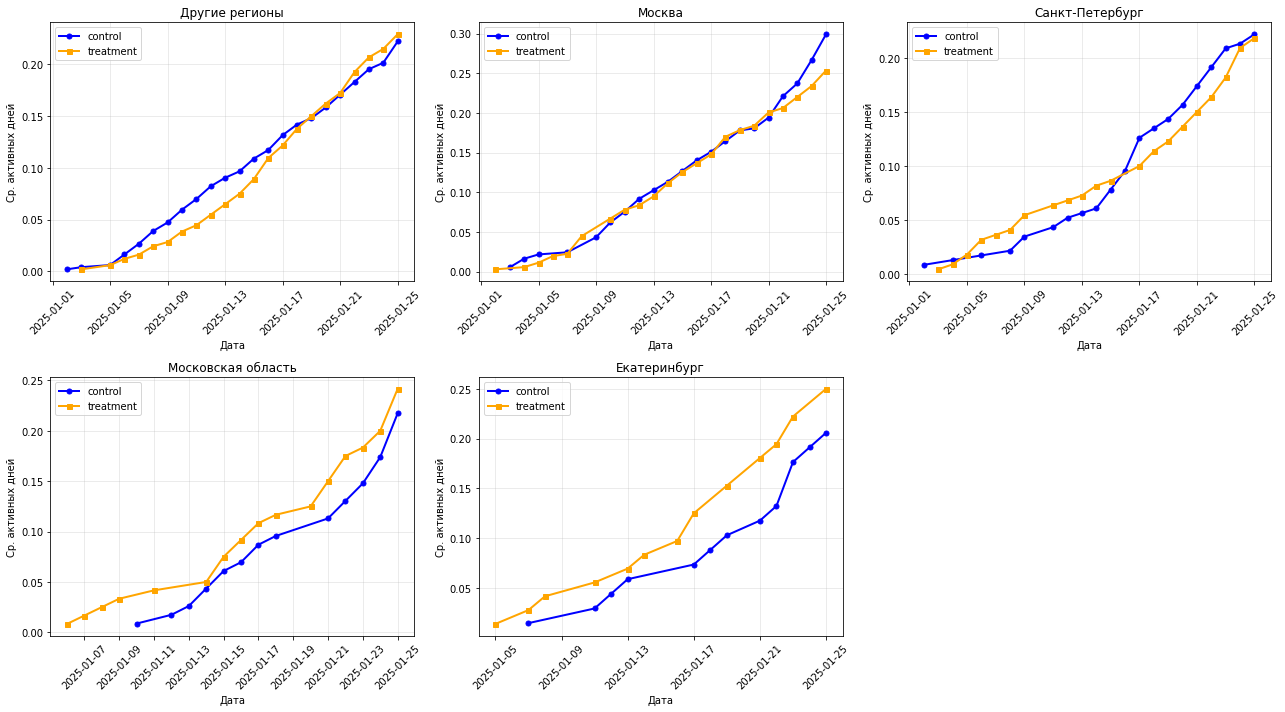

In [53]:
events_filtered = pa_marketplace_events_AB[
    (pa_marketplace_events_AB['event_date'] >= '2025-01-01') & 
    (pa_marketplace_events_AB['event_date'] <= '2025-01-26')
]

events_merged = events_filtered.merge(
    pa_marketplace_users_AB[['user_id', 'region']], 
    on='user_id', 
    how='inner'
).merge(
    pa_marketplace_AB_split_users[['user_id', 'group']], 
    on='user_id', 
    how='inner'
)

events_merged['event_date_only'] = events_merged['event_date'].dt.date

daily_active = events_merged.groupby(
    ['region', 'group', 'event_date_only', 'user_id']
).size().reset_index()

pivot_table = daily_active.pivot_table(
    index=['region', 'group', 'event_date_only'],
    values='user_id',
    aggfunc='nunique'
).reset_index()

pivot_table['cumulative_active'] = pivot_table.groupby(
    ['region', 'group']
)['user_id'].cumsum()

total_users_by_region_group = pa_marketplace_AB_split_users.merge(
    pa_marketplace_users_AB[['user_id', 'region']],
    on='user_id',
    how='inner'
).groupby(['region', 'group'])['user_id'].nunique().reset_index()
total_users_by_region_group.columns = ['region', 'group', 'total_users']

result_df = pivot_table.merge(
    total_users_by_region_group,
    on=['region', 'group'],
    how='left'
)
result_df['avg_active_days'] = result_df['cumulative_active'] / result_df['total_users']

top_regions = result_df['region'].value_counts().head(5).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, region in enumerate(top_regions):
    if idx >= len(axes):
        break
    
    region_data = result_df[result_df['region'] == region]
    
    for group, color, marker in [('control', 'blue', 'o'), ('treatment', 'orange', 's')]:
        group_data = region_data[region_data['group'] == group].sort_values('event_date_only')
        
        if not group_data.empty:
            axes[idx].plot(
                group_data['event_date_only'], 
                group_data['avg_active_days'], 
                label=group, 
                color=color, 
                marker=marker, 
                linewidth=2,
                markersize=5
            )
    
    axes[idx].set_title(f'{region}', fontsize=12)
    axes[idx].set_xlabel('Дата')
    axes[idx].set_ylabel('Ср. активных дней')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

for idx in range(len(top_regions), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

**В Московской области и Екатеренбурге новая система с бонусами положительно повлияла на активность пользователей.В остальных же регионах новвоведение не показала значимого отличия от контрольной грппы.**

**Выявили интересный инсайт: Фича не повлияла на активность пользователей из Москвы и Санкт-Петербурга,а также в других регионах(нужен более детальный анализ по кажому региону).Можно разобраться, с чем это связано. Первая гипотеза: пользователи из Москвы и СПБ действительно более активны, и новая фича на них влияет слабо. Вторая гипотеза: на пользователей из МСК и СПБ повлиял какой-то внешний фактор, который не был учтён в эксперименте.**

## Выводы по этапу 5

Представьте ключевые выводы в текстовом виде здесь или приложите ссылку на документ с презентацией.

Не забудьте предоставить доступ на просмотр и комментирование документа.

**Познакомился с дизайном теста,изучил данные и результаты сплита.**

**На этом этапе спарсил даты и отфильтровал данные которые были представлены за весь год. Проверив данные выявил что было выполнено хорошо:**
- Распределение хорошое(50.6%/49.4%)
- Все пользователи только из TikTok 
- Нет пользователей в обеих группах 
- Нет пользователей других каналов в сплите 

**Но уже на этом этапе присутсвуют и проблемы,которые могут исказить результаты теста**

**1)Тест длился больше установленного срока 25 дней вместо запланированных 21 дня. Сам тест и так выпадает на праздники,а сильный временой сдвиг ещё больше влият на результат.Первая часть данных отражает поведение во время праздников, а вторая — после них.**

**2)События начались со 2 января (возможно, пользователи не сразу активны после регистрации). Стоит уточнить эту техническую особеность у разработчиков и разобраться в ситуации**

**3)Эксперемент выпадает на праздники. В праздники люди меняют своё привычное поведение. Например, едут в отпуск или на дачу. Из-за этого эксперимент может показать завышенные или заниженные результаты. Запускать эксперимент в праздники можно, но важно верно интерпретировать результаты. В обычные дни они могут быть совсем другими.**

**Чтобы упростить процесс дизайна и снизить вероятность проблем, лучше следовать таким правилам:**

- Не запускать эксперименты в праздники и в период нестандартных событий.
- Всегда учитывать сезонность поведения пользователей. Например, если в продукте ярко выражена недельная сезонность, то длительность эксперимента должна быть кратна одной неделе.
- Не запускать эксперименты в четверг и пятницу: в выходные будет сложно отреагировать на возможные проблемы пользователей.

**Далее на этапе дизайна так же были выявлены проблемы:**

**1. Контекст и цель эксперимента**

**Ознакомился с бизнес контекстом и целью.Гипотеза должна быть конкретной и измеримой.Наша гипотеза в целом составлена хорошо,конечно можно было бы уточнить насколько должна увеличиться конверсия. На 1%? На 50%?.Если мы получим статистически значимое изменение,не факт что практически будет значим этот рост.**

**2. Формат эксперимента**

**В целом формат эксперемента понятен. Подход у нас с жёстко фиксированными параметрами(3 недели)**

**Это удобно для планирования, но нам нужно проверить параметры. Некоторые из них могут быть нерелевантны желаемому результату — например, может не хватить трафика для заданного MDE(Которого у нас нету из за срочности).**

**3.Ключевая метрика считаю подобрана правильно(как и вспомогательная так и барьерная).Единственное я бы предложил поменять кретерий успеха.**

**Считаю правильно он должен звучать так: Критерий успеха: статистически значимый рост конверсии в тестовой группе при отсутствие негативного влияния на барьерную метрику**

**4.Размеры групп и запуск**

**Крайне неправильно запускать тест при таких условиях: Комментарий: запуск без предварительного расчёта мощности и MDE из-за срочности задачи**

**Да мы можем увидеть статистическую значимость после проведения эксперимента, но будет ли она достаточной для бизнеса?Мб бизнесу нужно больше что бы окупиться и какой результат считать успехом? +1% уже хорошо оли нужно +15%?**

**Отсутствие расчёта мощьности приводи к то что неизвестно, достаточно ли 2,968 пользователей,а так же к риску ошибки 2-го рода: пропустить реальный эффект**

***Проведение эесперемента***

**Главный результат: бонус сработал эфективно**

- Конверсия выросла в 7 раз: с 1.06% до 7.51%
- Статистическая значимость: p-value = 1.58e-18 (крайне высокая)
- Барьерная метрика не пострадала: выручка в тестовой группе в 10 раз выше (192,280 руб. vs 18,919 руб.)

**Вспомогательные метрики так же показади положительную тенденцию**

- ARPU вырос с 72 до 808р.
- ARPPU увеличился с 1.182 до 1.748р.
- AOV  так же показал небольшой рост с 788 до 832р.

**Так же нашли интресный инсайт:**

**Фича не повлияла на активность пользователей из Москвы и Санкт-Петербурга,а также в других регионах(нужен более детальный анализ по кажому региону)**

**И выдвинули две новых гипотезы:**

- Пользователи из Москвы и СПБ действительно более активны, и новая фича на них влияет слабо.
- На пользователей из МСК и СПБ повлиял какой-то внешний фактор, который не был учтён в эксперименте.

**Рекомендции:**

**Несмотря на успешный тест и положительную динамику рекомендую перезапустить тест с учётом исправлений которые я описал выше. В дизайне проекта есть критические ошибки с которыми сложно сказать об  однозначном успехе теста. Эксперемент показал обнадёживающий результат,но из за критических ошибок в дизайне требует подтверждения.**

**В случае если бизнесу требуется внедрить бонусную систему без повторного теста с исправлениями в дизайне,рекомендую:**

- Не маштабировать на 100%
- Запустить пилот на 20% трафика TikTok с ежедневным мониторингом ключивых,вспомогательных и барьерных метрик






